In [1]:
MSASL_TRAIN_PATH = "./MS-ASL/MSASL_train.json"
MSASL_VAL_PATH = "./MS-ASL/MSASL_val.json"
MSASL_TEST_PATH = "./MS-ASL/MSASL_test.json"
MSASL_CLASSES_PATH = "./MS-ASL/MSASL_classes.json"

In [12]:
import json
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# --- Configuration ---
data_dir = "./MS-ASL"
skipped_file = "skipped_videos.txt"
synonym_file = "MSASL_synonym.json" # New: Path to the synonym file
subset_sizes = {
    "train": 1000,
    "val": 1000,
    "test": 1000
}
LABEL_KEY = "label" # Key in the JSON data that represents the label (e.g., sign word)

# --- Helper Functions ---

def load_skipped_urls(path):
    """
    Loads a set of skipped URLs from a text file.
    Each URL is expected to be on a new line.

    Args:
        path (str): The path to the file containing skipped URLs.

    Returns:
        set: A set of unique skipped URLs.
    """
    if not os.path.exists(path):
        print(f"Warning: Skipped file not found at {path}. Returning empty set.")
        return set()
        
    with open(path, "r") as f:
        urls = set(line.strip() for line in f if line.strip())
    print(f"Loaded {len(urls)} skipped URLs from '{path}'.")
    return urls

def load_synonym_mapping(path):
    """
    Loads the MSASL_synonym.json file and creates a mapping from synonyms
    to their canonical (primary) forms.

    Args:
        path (str): The path to the MSASL_synonym.json file.

    Returns:
        dict: A dictionary where keys are synonyms and values are their canonical forms.
              Returns an empty dict if the file is not found or parsing fails.
    """
    synonym_map = {}
    if not os.path.exists(path):
        print(f"Warning: Synonym file not found at {path}. No synonym mapping will be applied.")
        return synonym_map

    try:
        with open(path, "r") as f:
            synonym_data = json.load(f)
        
        if not isinstance(synonym_data, list):
            print(f"Error: Expected synonym JSON to be a list, but got {type(synonym_data)}. No synonym mapping applied.")
            return synonym_map

        for group in synonym_data:
            if isinstance(group, list) and len(group) > 0:
                canonical_form = str(group[0]).strip() # First element is the canonical form
                for synonym in group:
                    synonym_map[str(synonym).strip()] = canonical_form
        print(f"Loaded {len(synonym_map)} synonym entries from '{path}'.")
    except json.JSONDecodeError as e:
        print(f"Error: Failed to parse {path}: {e}. No synonym mapping applied.")
    except Exception as e:
        print(f"An unexpected error occurred while loading synonyms from {path}: {e}. No synonym mapping applied.")
    
    return synonym_map

def load_and_filter_all_data(data_directory, skipped_urls, synonym_map, splits=["train", "val", "test"]):
    """
    Loads data from all specified JSON files, combines them,
    applies synonym mapping to labels, and filters out entries with bad URLs.

    Args:
        data_directory (str): The directory containing the MSASL JSON files.
        skipped_urls (set): A set of URLs to be excluded.
        synonym_map (dict): A dictionary mapping synonyms to canonical labels.
        splits (list): A list of dataset splits to load (e.g., ["train", "val", "test"]).

    Returns:
        pd.DataFrame: A single DataFrame containing all loaded, cleaned, and normalized data,
                      with an 'original_split' column indicating its source.
                      Returns an empty DataFrame if no data is loaded.
    """
    all_data = []
    
    print("\n--- Loading and Combining Raw Data ---")
    for split in splits:
        input_json_path = os.path.join(data_directory, f"MSASL_{split}.json")
        if not os.path.exists(input_json_path):
            print(f"Warning: Input JSON file not found: {input_json_path}. Skipping.")
            continue
            
        with open(input_json_path, "r") as f:
            try:
                data = json.load(f)
                # Apply synonym mapping and add original_split
                for item in data:
                    if LABEL_KEY in item and item[LABEL_KEY] is not None:
                        original_label = str(item[LABEL_KEY]).strip()
                        # Apply mapping: if label is a synonym, use its canonical form
                        item[LABEL_KEY] = synonym_map.get(original_label, original_label)
                    item['original_split'] = split
                all_data.extend(data)
                print(f"Loaded {len(data)} entries from '{input_json_path}'.")
            except json.JSONDecodeError as e:
                print(f"Error: Failed to parse {input_json_path}: {e}. Skipping this file.")
            except Exception as e:
                print(f"An unexpected error occurred while loading {input_json_path}: {e}")

    if not all_data:
        print("No data loaded from any JSON files. Exiting.")
        return pd.DataFrame()

    master_df = pd.DataFrame(all_data)
    print(f"Total entries loaded across all splits: {len(master_df)}")

    # Filter out entries with skipped URLs
    initial_count = len(master_df)
    master_df['url'] = master_df['url'].fillna('').astype(str).str.strip() # Ensure URL is string and strip whitespace
    filtered_df = master_df[~master_df['url'].isin(skipped_urls)].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    skipped_count = initial_count - len(filtered_df)
    print(f"Skipped {skipped_count} entries due to bad URLs from 'skipped_videos.txt'.")
    print(f"Remaining entries after filtering: {len(filtered_df)}")
    
    return filtered_df

def perform_stratified_subsetting(master_df, target_subset_sizes, label_key=LABEL_KEY):
    """
    Performs stratified splitting and then takes a random sample up to the target size
    for each split (train, val, test). Ensures disjoint instances across splits.

    Args:
        master_df (pd.DataFrame): The DataFrame containing all cleaned data.
        target_subset_sizes (dict): Dictionary with desired sizes for "train", "val", "test".
        label_key (str): The column name for labels in the DataFrame.

    Returns:
        dict: A dictionary containing DataFrames for 'train', 'val', and 'test' subsets.
    """
    if master_df.empty:
        print("Master DataFrame is empty. Cannot perform stratified subsetting.")
        return {"train": pd.DataFrame(), "val": pd.DataFrame(), "test": pd.DataFrame()}

    # Ensure the label column exists and handle potential NaNs in labels
    if label_key not in master_df.columns:
        print(f"Error: Label key '{label_key}' not found in DataFrame. Cannot perform stratified split.")
        return {"train": pd.DataFrame(), "val": pd.DataFrame(), "test": pd.DataFrame()}
    
    # Drop rows with NaN labels for stratified splitting, as sklearn cannot handle them
    df_for_split = master_df.dropna(subset=[label_key]).copy()
    if df_for_split.empty:
        print("No data remaining after dropping rows with missing labels. Cannot perform stratified split.")
        return {"train": pd.DataFrame(), "val": pd.DataFrame(), "test": pd.DataFrame()}

    # Calculate proportions for splitting
    # First, split into training+validation and test sets
    test_size_ratio = target_subset_sizes.get("test", 0) / len(df_for_split)
    if test_size_ratio >= 1.0: # Handle cases where test size is too large
        print(f"Warning: Test size ({target_subset_sizes.get('test', 0)}) is too large for total data ({len(df_for_split)}). Adjusting.")
        test_size_ratio = 0.2 # Default to 20% test if invalid
    
    # Ensure there are enough samples per class for stratification
    # If a class has only 1 sample, it cannot be split.
    # We'll handle this by trying to split, and if it fails, fallback to non-stratified.
    try:
        train_val_df, test_df_stratified = train_test_split(
            df_for_split, test_size=test_size_ratio, random_state=42, stratify=df_for_split[label_key]
        )
    except ValueError as e:
        print(f"Warning: Stratified split for test set failed ({e}). Falling back to non-stratified split.")
        train_val_df, test_df_stratified = train_test_split(
            df_for_split, test_size=test_size_ratio, random_state=42
        )

    # Then, split training+validation into training and validation sets
    val_size_ratio = target_subset_sizes.get("val", 0) / len(train_val_df)
    if val_size_ratio >= 1.0: # Handle cases where val size is too large
        print(f"Warning: Validation size ({target_subset_sizes.get('val', 0)}) is too large for train_val data ({len(train_val_df)}). Adjusting.")
        val_size_ratio = 0.2 # Default to 20% validation if invalid

    try:
        train_df_stratified, val_df_stratified = train_test_split(
            train_val_df, test_size=val_size_ratio, random_state=42, stratify=train_val_df[label_key]
        )
    except ValueError as e:
        print(f"Warning: Stratified split for validation set failed ({e}). Falling back to non-stratified split.")
        train_df_stratified, val_df_stratified = train_test_split(
            train_val_df, test_size=val_size_ratio, random_state=42
        )

    # Now, take random samples up to the target subset sizes from these stratified sets
    final_subsets = {}
    for split_name, df_stratified in [("train", train_df_stratified), 
                                      ("val", val_df_stratified), 
                                      ("test", test_df_stratified)]:
        target_size = target_subset_sizes.get(split_name, 0)
        
        if len(df_stratified) < target_size:
            print(f"Warning: Not enough entries for {split_name} ({len(df_stratified)} available, {target_size} requested). Using all available.")
            final_subsets[split_name] = df_stratified.sample(frac=1, random_state=42).reset_index(drop=True)
        else:
            final_subsets[split_name] = df_stratified.sample(n=target_size, random_state=42).reset_index(drop=True)
            
    return final_subsets

def save_json_array(data_df, output_path):
    """
    Saves a pandas DataFrame to a JSON file in array format,
    handling NaN values by converting them to None (JSON null).

    Args:
        data_df (pd.DataFrame): The DataFrame to save.
        output_path (str): The path to the output JSON file.
    """
    # Replace all NaN values in the DataFrame with None
    # This is the most robust way to handle NaN for JSON serialization
    df_cleaned = data_df.replace({np.nan: None})

    # Convert DataFrame to list of dictionaries
    data_list = df_cleaned.to_dict(orient='records')

    with open(output_path, "w") as f:
        json.dump(data_list, f, indent=2)
        
    print(f"Saved {len(data_list)} entries to: {output_path}")

# --- Main Execution Flow ---
if __name__ == "__main__":
    # 1. Load skipped URLs
    skipped_urls = load_skipped_urls(skipped_file)

    # 2. Load synonym mapping
    synonym_map = load_synonym_mapping(os.path.join(data_dir, synonym_file))

    # 3. Load all original data, apply synonym mapping, and filter by skipped URLs
    master_filtered_df = load_and_filter_all_data(data_dir, skipped_urls, synonym_map)

    if master_filtered_df.empty:
        print("No valid data to process after loading and filtering. Exiting.")
    else:
        # 4. Perform stratified splitting and subsetting
        print("\n--- Performing Stratified Subsetting ---")
        final_subsets = perform_stratified_subsetting(master_filtered_df, subset_sizes)

        # 5. Save the new subset JSON files
        print("\n--- Saving Subsets ---")
        for split_name, df_subset in final_subsets.items():
            output_json = os.path.join(data_dir, f"MSASL_{split_name}_subset.json")
            save_json_array(df_subset, output_json)

        print("\nDataset preparation complete.")
        print(f"Final Train subset size: {len(final_subsets['train'])}")
        print(f"Final Validation subset size: {len(final_subsets['val'])}")
        print(f"Final Test subset size: {len(final_subsets['test'])}")

        # Optional: Print unique labels for each subset to verify distribution
        print("\n--- Unique Labels in Final Subsets ---")
        for split_name, df_subset in final_subsets.items():
            if not df_subset.empty and LABEL_KEY in df_subset.columns:
                unique_labels = df_subset[LABEL_KEY].nunique()
                print(f"{split_name.capitalize()}: {unique_labels} unique labels")
            else:
                print(f"{split_name.capitalize()}: No data or '{LABEL_KEY}' column missing.")

Loaded 4 skipped URLs from 'skipped_videos.txt'.
Loaded 588 synonym entries from './MS-ASL/MSASL_synonym.json'.

--- Loading and Combining Raw Data ---
Loaded 16054 entries from './MS-ASL/MSASL_train.json'.
Loaded 5287 entries from './MS-ASL/MSASL_val.json'.
Loaded 4172 entries from './MS-ASL/MSASL_test.json'.
Total entries loaded across all splits: 25513
Skipped 181 entries due to bad URLs from 'skipped_videos.txt'.
Remaining entries after filtering: 25332

--- Performing Stratified Subsetting ---

--- Saving Subsets ---
Saved 1000 entries to: ./MS-ASL/MSASL_train_subset.json
Saved 1000 entries to: ./MS-ASL/MSASL_val_subset.json
Saved 1000 entries to: ./MS-ASL/MSASL_test_subset.json

Dataset preparation complete.
Final Train subset size: 1000
Final Validation subset size: 1000
Final Test subset size: 1000

--- Unique Labels in Final Subsets ---
Train: 593 unique labels
Val: 822 unique labels
Test: 827 unique labels


In [13]:
MSASL_CLASSES_PATH = "./MS-ASL/MSASL_classes.json"

In [ ]:
import os
import json
import pandas as pd
import yt_dlp
import shutil
import cv2
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# Configuration
OUTPUT_DIR = "./msasl_clips/"
MIN_CLIP_DURATION = 0 # Currently not used, but good to have for future filtering
TARGET_RESOLUTION = (256, 256)
LABEL_NAME = "label" # Key for the label in your JSON data

# --- Optimization for Speed ---
# Maximize concurrent processes for downloads and video processing.
# os.cpu_count() returns the number of logical CPU cores.
# You can experiment with higher values (e.g., os.cpu_count() * 2)
# if your network bandwidth is very high and you want more concurrent downloads,
# but be mindful of saturating your network or disk I/O.
MAX_WORKERS = os.cpu_count() if os.cpu_count() else 4
print(f"Using {MAX_WORKERS} parallel workers.")

# --- Initial Setup ---
# Remove existing output directory to start fresh
if os.path.exists(OUTPUT_DIR):
    print(f"Removing existing output directory: {OUTPUT_DIR}")
    shutil.rmtree(OUTPUT_DIR)
# Create the output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Clear or create the skipped_videos.txt file
open("skipped_videos.txt", "w").close()
print(f"Output directory '{OUTPUT_DIR}' initialized.")
print(f"Skipped videos log 'skipped_videos.txt' cleared.")

# --- Helper Functions ---

def robust_json_loader(file_path):
    """
    Loads a JSON file which is expected to be a single JSON array.
    Applies standardization to 'box' coordinates and handles parsing errors.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the loaded and cleaned data.
                      Returns an empty DataFrame if a fatal error occurs.
    """
    data = []
    error_count = 0
    
    print(f"Attempting to load and parse: {file_path}")
    try:
        with open(file_path, 'r') as f:
            # Load the entire JSON file as a single object (expected to be a list)
            raw_data = json.load(f)
        
        # Ensure raw_data is a list before proceeding
        if not isinstance(raw_data, list):
            print(f"Error: Expected JSON array but got {type(raw_data)} from {file_path}")
            return pd.DataFrame()

        # Process each item in the loaded list
        for item in tqdm(raw_data, desc=f"Cleaning & Standardizing {os.path.basename(file_path)}"):
            try:
                # Standardize box format if 'box' key exists
                if 'box' in item:
                    if isinstance(item['box'], dict):
                        # Convert dictionary box to list [x1, y1, x2, y2]
                        # Default to 0.0 for x1, y1 and 1.0 for x2, y2 if keys are missing
                        item['box'] = [
                            float(item['box'].get('0', 0.0)),
                            float(item['box'].get('1', 0.0)),
                            float(item['box'].get('2', 1.0)),
                            float(item['box'].get('3', 1.0))
                        ]
                    elif not (isinstance(item['box'], list) and len(item['box']) == 4):
                        # If 'box' is not a dict or a 4-element list, set to default
                        item['box'] = [0.0, 0.0, 1.0, 1.0]
                else:
                    # If 'box' key is missing, add default box
                    item['box'] = [0.0, 0.0, 1.0, 1.0]
                
                data.append(item)
            except (KeyError, ValueError) as e:
                error_count += 1
                # print(f"Warning: Error processing item in {file_path}: {e}") # Uncomment for detailed item errors
                continue
        
        print(f"Loaded {len(data)} valid items with {error_count} skipped/errors from {file_path}")
        return pd.DataFrame(data)
    
    except json.JSONDecodeError as e:
        print(f"Fatal JSON parsing error for {file_path}: {e}")
        return pd.DataFrame()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while loading {file_path}: {str(e)}")
        return pd.DataFrame()

def process_video(row, split):
    """
    Downloads, processes (crops and resizes), and saves a single video clip.
    Handles various errors during download and video processing.

    Args:
        row (pd.Series): A row from the DataFrame containing video metadata.
        split (str): The dataset split (e.g., 'train', 'val', 'test').

    Returns:
        str: A message indicating the outcome of the processing (success or error).
    """
    temp_path = None
    video_url = row.get('url', 'N/A') # Default to 'N/A' if URL is missing for error logging
    
    try:
        # Validate required fields
        required_fields = ['url', 'start_time', 'end_time', 'file', LABEL_NAME]
        if any(field not in row or pd.isna(row[field]) for field in required_fields):
            return f"Skipping {video_url}: Missing or NaN required fields in row."
        
        start = float(row['start_time'])
        end = float(row['end_time'])
        label = str(row[LABEL_NAME])
        # Sanitize filename to avoid issues with path creation
        filename_base = str(row['file']).replace(" ", "_").replace("/", "_").replace("\\", "_")
        filename = f"{filename_base}_{split}"
        
        # Setup output paths
        label_dir = os.path.join(OUTPUT_DIR, split, label)
        os.makedirs(label_dir, exist_ok=True)
        output_path = os.path.join(label_dir, f"{filename}.mp4")
        
        if os.path.exists(output_path):
            return f"Skipped (clip already exists): {output_path}"
        
        # Setup temporary download directory
        temp_dir = os.path.join(OUTPUT_DIR, "temp")
        os.makedirs(temp_dir, exist_ok=True)
        temp_path = os.path.join(temp_dir, f"{filename}.mp4")
        
        # --- Download video using yt_dlp ---
        ydl_opts = {
            'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
            'outtmpl': temp_path,
            'quiet': True,
            'no_warnings': True,
            'retries': 3,
            'fragment_retries': 3, # Add fragment retries for robustness
            'extractor_retries': 3, # Add extractor retries
        }
        
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            # Check video duration before downloading to avoid unnecessary downloads
            info = ydl.extract_info(video_url, download=False)
            video_duration = info.get('duration', float('inf'))
            clip_duration = end - start

            if video_duration < clip_duration:
                return f"Skipping {video_url}: Video (duration={video_duration:.2f}s) is shorter than requested clip ({clip_duration:.2f}s)."
            
            ydl.download([video_url])
        
        # --- Process video frames with OpenCV ---
        cap = cv2.VideoCapture(temp_path)
        if not cap.isOpened():
            return f"Error: Failed to open downloaded video for processing: {temp_path}"
        
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps == 0: # Handle cases where FPS might be reported as 0
            fps = 30 
            # print(f"Warning: FPS reported as 0 for {temp_path}, defaulting to 30 FPS.")

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        start_frame = int(start * fps)
        end_frame = min(int(end * fps), total_frames - 1)
        
        # Ensure start_frame is not beyond end_frame
        if start_frame >= total_frames:
            cap.release()
            return f"Skipping {video_url}: Start time {start}s is beyond video duration."

        # Retrieve box coordinates (already standardized by robust_json_loader)
        box = row.get('box', [0.0, 0.0, 1.0, 1.0])
        
        # Initialize video writer
        writer = cv2.VideoWriter(
            output_path,
            cv2.VideoWriter_fourcc(*'mp4v'), # Use 'mp4v' for broader compatibility
            fps,
            TARGET_RESOLUTION
        )
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        frames_processed = 0
        
        for frame_idx in range(start_frame, end_frame + 1):
            ret, frame = cap.read()
            if not ret:
                # Break if no more frames or an error occurred reading
                break
            
            h, w = frame.shape[:2]
            # Calculate pixel coordinates from normalized box
            x1, y1 = int(box[0] * w), int(box[1] * h)
            x2, y2 = int(box[2] * w), int(box[3] * h)
            
            # Ensure valid coordinates within frame boundaries
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            
            if x2 > x1 and y2 > y1: # Ensure crop area is valid
                cropped = frame[y1:y2, x1:x2]
                resized = cv2.resize(cropped, TARGET_RESOLUTION)
                writer.write(resized)
                frames_processed += 1
            else:
                # If box coordinates are invalid, still try to write a resized frame
                # This might happen if the box is outside the video bounds or malformed
                resized = cv2.resize(frame, TARGET_RESOLUTION)
                writer.write(resized)
                frames_processed += 1 # Count even if box was invalid, as a frame was written
                # print(f"Warning: Invalid box coordinates for {video_url}. Writing full frame.")

        cap.release()
        writer.release()
        
        if frames_processed == 0:
            # If no frames were processed, remove the empty output file
            if os.path.exists(output_path):
                os.remove(output_path)
            return f"Error: No valid frames processed for {video_url}. Output file removed."
        
        return f"Success: {output_path} ({frames_processed} frames written)"
    
    except yt_dlp.utils.DownloadError as e:
        error_msg = f"Download Error for {video_url}: {str(e)}"
        # Log unavailable/private/removed videos
        if any(x in str(e).lower() for x in ['unavailable', 'private', 'removed', 'not found', 'forbidden']):
            with open("skipped_videos.txt", "a") as f:
                f.write(f"{video_url}\n")
        return error_msg
    except Exception as e:
        error_msg = f"Unhandled Error processing {video_url}: {str(e)}"
        return error_msg
    finally:
        # Clean up temporary downloaded video file
        if temp_path and os.path.exists(temp_path):
            try:
                os.remove(temp_path)
            except OSError as e:
                print(f"Warning: Could not remove temporary file {temp_path}: {e}")

def process_dataset():
    """
    Main function to load dataset subsets and process videos in parallel.
    """
    DATA_DIR = "./MS-ASL/" # Assuming MS-ASL_train_subset.json etc. are in this directory
    train_path = os.path.join(DATA_DIR, "MSASL_train_subset.json")
    val_path = os.path.join(DATA_DIR, "MSASL_val_subset.json")
    test_path = os.path.join(DATA_DIR, "MSASL_test_subset.json")
    
    # Load datasets using the improved robust_json_loader
    train_df = robust_json_loader(train_path)
    val_df = robust_json_loader(val_path)
    test_df = robust_json_loader(test_path)
    
    # Verify data loading
    print("\n--- Dataset Summary ---")
    print(f"Train samples loaded: {len(train_df)}")
    print(f"Validation samples loaded: {len(val_df)}")
    print(f"Test samples loaded: {len(test_df)}")
    
    if train_df.empty and val_df.empty and test_df.empty:
        print("Error: No datasets were loaded successfully. Exiting.")
        return
    
    # Process each split
    for split_name, df in [("train", train_df), ("val", val_df), ("test", test_df)]:
        if df.empty:
            print(f"\nSkipping {split_name} split as no data was loaded.")
            continue

        print(f"\n--- Processing {split_name} split ({len(df)} videos) ---")
        
        # Prepare tasks for parallel execution
        tasks = [(row, split_name) for _, row in df.iterrows()]
        
        # Use ProcessPoolExecutor for parallel video processing
        # `chunksize` can be adjusted for performance, but 1 is fine for small tasks
        with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
            futures = [executor.submit(process_video, row, split) for row, split in tasks]
            
            # Use tqdm to show progress for the parallel tasks
            for future in tqdm(as_completed(futures), total=len(tasks), desc=f"Processing {split_name} videos"):
                result = future.result()
                # print(result) # Uncomment to see individual video processing results
        print(f"Finished processing {split_name} split.")

# --- Main Execution ---
if __name__ == "__main__":
    process_dataset()

Using 12 parallel workers.
Removing existing output directory: ./msasl_clips/
Output directory './msasl_clips/' initialized.
Skipped videos log 'skipped_videos.txt' cleared.
Attempting to load and parse: ./MS-ASL/MSASL_train_subset.json


Cleaning & Standardizing MSASL_train_subset.json: 100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1482086.22it/s]


Loaded 1000 valid items with 0 skipped/errors from ./MS-ASL/MSASL_train_subset.json
Attempting to load and parse: ./MS-ASL/MSASL_val_subset.json


Cleaning & Standardizing MSASL_val_subset.json: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 924466.39it/s]


Loaded 1000 valid items with 0 skipped/errors from ./MS-ASL/MSASL_val_subset.json
Attempting to load and parse: ./MS-ASL/MSASL_test_subset.json


Cleaning & Standardizing MSASL_test_subset.json: 100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1184497.03it/s]

Loaded 1000 valid items with 0 skipped/errors from ./MS-ASL/MSASL_test_subset.json

--- Dataset Summary ---
Train samples loaded: 1000
Validation samples loaded: 1000
Test samples loaded: 1000

--- Processing train split (1000 videos) ---



Processing train videos:   0%|                                                                                                            | 1/1000 [00:02<42:03,  2.53s/it]ERROR: [youtube] lSxAVvE9sPc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] o4ToXoTzh1A: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERRO

[download]   6.7% of ~  13.45MiB at    1.70MiB/s ETA Unknown (frag 4/49)

ERROR: [youtube] TwkGS9TjUX8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   3%|███                                                                                                        | 29/1000 [00:09<04:54,  3.30it/s]

[download]  18.5% of ~  11.85MiB at    3.17MiB/s ETA Unknown (frag 10/49)

ERROR: [youtube] SJAhRxI7i9c: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   3%|███▏                                                                                                       | 30/1000 [00:09<04:52,  3.32it/s]ERROR: [youtube] si01coqVYiA: Video unavailable
ERROR: [youtube] WxY7E9P46DM: Requested format is not available. Use --list-formats for a list of available formats


[download]  24.8% of ~  11.19MiB at    3.24MiB/s ETA Unknown (frag 13/49)

ERROR: [youtube] b3fpYsD6kr8: Requested format is not available. Use --list-formats for a list of available formats


[download]  28.6% of ~   9.71MiB at    3.33MiB/s ETA Unknown (frag 13/49)

Processing train videos:   3%|███▌                                                                                                       | 33/1000 [00:09<02:57,  5.46it/s]

[download]  30.9% of ~  10.71MiB at    3.40MiB/s ETA Unknown (frag 16/49)

ERROR: [youtube] 8OGGZyG8S9g: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   3%|███▋                                                                                                       | 34/1000 [00:09<02:43,  5.92it/s]ERROR: [youtube] jQTwaySU-yY: Video unavailable


[download]  36.7% of ~  10.89MiB at    3.61MiB/s ETA 00:01 (frag 19/49)  

ERROR: [youtube] g5VCwKZib-M: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   4%|███▊                                                                                                       | 36/1000 [00:09<02:08,  7.52it/s]

[download]  53.5% of ~  10.45MiB at    3.68MiB/s ETA 00:01 (frag 27/49)

ERROR: [youtube] 8hBFgtJOZaE: Requested format is not available. Use --list-formats for a list of available formats


[download]  71.5% of ~  10.35MiB at    3.71MiB/s ETA 00:01 (frag 36/49)

ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   4%|████                                                                                                       | 38/1000 [00:10<03:59,  4.01it/s]

[download]  77.2% of ~  10.52MiB at    3.69MiB/s ETA 00:00 (frag 39/49)

ERROR: [youtube] uM98W6WkvK0: Video unavailable
Processing train videos:   4%|████▏                                                                                                      | 39/1000 [00:11<03:47,  4.22it/s]

ERROR: [youtube] oDnz2t98VYk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:   4%|████▎                                                                                                      | 40/1000 [00:11<05:18,  3.02it/s]

[download]   9.6% of ~   3.25MiB at  793.43KiB/s ETA Unknown (frag 3/28)

ERROR: [youtube] MIPvaUKFA4c: Requested format is not available. Use --list-formats for a list of available formats


[download]   9.7% of ~   3.26MiB at  793.43KiB/s ETA Unknown (frag 3/28)

Processing train videos:   4%|████▍                                                                                                      | 41/1000 [00:11<04:40,  3.42it/s]

[download]  14.3% of ~   4.32MiB at    1.50MiB/s ETA Unknown (frag 5/28)

ERROR: [youtube] PvzBgEcEPew: Requested format is not available. Use --list-formats for a list of available formats


[download]  17.9% of ~   4.32MiB at    1.67MiB/s ETA Unknown (frag 6/28)

ERROR: [youtube] TYEae1fcehg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   4%|████▌                                                                                                      | 43/1000 [00:12<03:18,  4.82it/s]

[download]  42.9% of ~   4.32MiB at    2.46MiB/s ETA Unknown (frag 13/28)

ERROR: [youtube] ukG3s9WX7U4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   4%|████▋                                                                                                      | 44/1000 [00:12<03:40,  4.34it/s]

[download]  46.4% of ~   4.32MiB at    2.53MiB/s ETA Unknown (frag 14/28)

ERROR: [youtube] 821mepSrKik: Requested format is not available. Use --list-formats for a list of available formats


[download]  50.0% of ~   4.32MiB at    2.57MiB/s ETA Unknown (frag 15/28)

ERROR: [youtube] iJwNP8oNphY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   5%|████▉                                                                                                      | 46/1000 [00:12<02:35,  6.13it/s]

[download]  67.9% of ~   4.32MiB at    2.76MiB/s ETA Unknown (frag 20/28)

ERROR: [youtube] Tg0ltpSAQrk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   5%|█████                                                                                                      | 47/1000 [00:12<02:49,  5.62it/s]

[download]  85.7% of ~   4.32MiB at    2.82MiB/s ETA 00:00 (frag 25/28)  

ERROR: [youtube] N4n5CDpyX3w: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   5%|█████▏                                                                                                     | 48/1000 [00:13<03:17,  4.82it/s]

ERROR: [youtube] OAolTbu5Ngk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   5%|█████▌                                                                                                     | 52/1000 [00:13<02:54,  5.43it/s]ERROR: [youtube] d3hz26r_ulw: Video unavailable
ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:   6%|██████                                                                                                     | 57/1000 [00:14<03:15,  4.83it/s]ERROR: [youtube] 6r8HDsBMk1E: Requested format is not available. Use --list-format

Processing train videos:   8%|████████▉                                                                                                  | 83/1000 [00:21<04:50,  3.15it/s]

[download]  25.0% of ~   2.31KiB at    631.92B/s ETA Unknown (frag 1/2)

ERROR: [youtube] YfzIHzZRetw: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   8%|████████▉                                                                                                  | 84/1000 [00:21<04:19,  3.53it/s]

Processing train videos:   8%|█████████                                                                                                  | 85/1000 [00:21<05:03,  3.01it/s]ERROR: [youtube] otTiJBUrJmI: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] Jl02T1KXfBc: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   9%|█████████▋                                                                                                 | 91/1000 [00:22<02:59,  5.06it/s]ERROR: [youtube] MRhaDlslxF8: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] KRrKqGEGdMg: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] ZHUVt5W8UEk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:   9%|██████████                                      

[download]  10.0% of ~   2.48MiB at   58.85KiB/s ETA 00:05 (frag 0/20)

ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  10%|██████████▎                                                                                                | 96/1000 [00:24<04:45,  3.17it/s]ERROR: [youtube] 1ebUDpd-7DE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   2.5% of ~  38.45MiB at  198.63KiB/s ETA 00:08 (frag 1/20)

ERROR: [youtube] 55iIOV3hosM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  10%|██████████▍                                                                                                | 98/1000 [00:24<04:04,  3.69it/s]ERROR: [youtube] FRQbKDZeRzM: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] rWIDL_GpaJc: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] 6Mmgrtw_Zro: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  10%|██████████▋                                                                                               | 101/1000 [00:25<03:19,  4.51it/s]

[download]  10.3% of ~   9.92MiB at  439.56KiB/s ETA 00:10 (frag 1/20)

ERROR: [youtube] UI5KLVn8JKI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  10%|██████████▊                                                                                               | 102/1000 [00:25<03:28,  4.31it/s]

[download]  10.6% of ~  10.23MiB at  473.26KiB/s ETA 00:11 (frag 1/20)

ERROR: [youtube] AiozVha_k4o: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  10%|██████████▉                                                                                               | 103/1000 [00:25<03:07,  4.79it/s]ERROR: [youtube] 2bXFhqq9YxA: Requested format is not available. Use --list-formats for a list of available formats


[download]  12.1% of ~  12.10MiB at  552.29KiB/s ETA 00:12 (frag 1/20)

ERROR: [youtube] Cv5avR9nEhg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  10%|███████████▏                                                                                              | 105/1000 [00:25<02:36,  5.71it/s]

[download]   6.7% of ~  28.50MiB at  633.41KiB/s ETA 00:12 (frag 2/20)

ERROR: [youtube] k0T-yY_HrEQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  11%|███████████▏                                                                                              | 106/1000 [00:26<02:42,  5.50it/s]ERROR: [youtube] V_CmcX4SF3s: Video unavailable
ERROR: [youtube] nByL5JU11tU: Video unavailable


[download]  25.8% of ~  16.10MiB at    1.03MiB/s ETA 00:12 (frag 4/20)

ERROR: [youtube] V7WEPn3RJsc: Video unavailable
Processing train videos:  11%|███████████▌                                                                                              | 109/1000 [00:27<04:28,  3.32it/s]

[download]  20.8% of ~  23.57MiB at    1.12MiB/s ETA 00:12 (frag 5/20)

ERROR: [youtube] 7OHUQbBmm6U: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  11%|███████████▋                                                                                              | 110/1000 [00:27<04:20,  3.42it/s]ERROR: [youtube] 99noLwmY2Bc: Requested format is not available. Use --list-formats for a list of available formats


[download]  35.7% of ~  17.26MiB at    1.58MiB/s ETA 00:10 (frag 6/20)

ERROR: [youtube] 6cigtOP682Y: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  11%|███████████▊                                                                                              | 112/1000 [00:28<03:55,  3.77it/s]ERROR: [youtube] eBkzZg-9hd4: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] _ct_E9MU_2U: Requested format is not available. Use --list-formats for a list of available formats


[download]  30.5% of ~  22.74MiB at    1.67MiB/s ETA 00:10 (frag 7/20)

ERROR: [youtube] G0IHRXJ8VVY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  12%|████████████▏                                                                                             | 115/1000 [00:28<02:52,  5.14it/s]

[download]  40.7% of ~  17.66MiB at    1.76MiB/s ETA 00:09 (frag 7/20)

ERROR: [youtube] p2xuU6C_p0Y: Requested format is not available. Use --list-formats for a list of available formats


[download]  41.4% of ~  17.97MiB at    1.76MiB/s ETA 00:09 (frag 7/20)

Processing train videos:  12%|████████████▎                                                                                             | 116/1000 [00:28<02:41,  5.47it/s]

[download]  45.7% of ~  17.92MiB at    2.02MiB/s ETA 00:08 (frag 8/20)

ERROR: [youtube] Tg0ltpSAQrk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  12%|████████████▍                                                                                             | 117/1000 [00:29<03:28,  4.23it/s]ERROR: [youtube] FKcrtW0JkyA: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] 9g-hioQapYE: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] qDW0SM1C724: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  12%|████████████▋                          

[download]  40.4% of ~  22.12MiB at    2.09MiB/s ETA 00:08 (frag 9/20)

ERROR: [youtube] SSDg9Y4a-ec: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  60.0% of ~  18.19MiB at    2.43MiB/s ETA 00:06 (frag 11/20)

ERROR: [youtube] CaPskXAkgJo: Requested format is not available. Use --list-formats for a list of available formats


[download]  60.0% of ~  18.19MiB at    2.43MiB/s ETA 00:06 (frag 11/20)

Processing train videos:  12%|████████████▉                                                                                             | 122/1000 [00:30<04:00,  3.65it/s]

[download]  60.3% of ~  21.43MiB at    2.57MiB/s ETA 00:05 (frag 13/20)

ERROR: [youtube] cF6XScPZDsE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  12%|█████████████▏                                                                                            | 124/1000 [00:30<04:02,  3.61it/s]

[download]  65.3% of ~  21.35MiB at    2.58MiB/s ETA 00:04 (frag 14/20)

ERROR: [youtube] 60omp0MhwPU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  12%|█████████████▎                                                                                            | 125/1000 [00:31<04:11,  3.48it/s]ERROR: [youtube] lbw6sdq2XxA: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] 73icFhednQU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  70.3% of ~  21.24MiB at    2.61MiB/s ETA 00:04 (frag 15/20)

ERROR: [youtube] Cv5avR9nEhg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  13%|█████████████▌                                                                                            | 128/1000 [00:31<02:53,  5.03it/s]

[download]  75.3% of ~  21.16MiB at    2.61MiB/s ETA 00:03 (frag 16/20)

ERROR: [youtube] qGEfRGh0pWM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  13%|█████████████▋                                                                                            | 129/1000 [00:31<03:11,  4.54it/s]

[download]  85.0% of ~  18.74MiB at    2.63MiB/s ETA 00:03 (frag 16/20)

ERROR: [youtube] shPBfkIYYpU: Requested format is not available. Use --list-formats for a list of available formats


[download]  85.0% of ~  18.74MiB at    2.63MiB/s ETA 00:03 (frag 16/20)

Processing train videos:  13%|█████████████▊                                                                                            | 130/1000 [00:32<03:09,  4.59it/s]

[download]  85.0% of ~  19.92MiB at    2.73MiB/s ETA 00:03 (frag 16/20)

ERROR: [youtube] iDWntsY_rZM: Video unavailable


[download]  80.3% of ~  21.10MiB at    2.73MiB/s ETA 00:03 (frag 17/20)

ERROR: [youtube] x0q-NTYinOY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  13%|██████████████                                                                                            | 133/1000 [00:32<02:16,  6.33it/s]

[download]  85.2% of ~  21.04MiB at    2.86MiB/s ETA 00:02 (frag 18/20)

ERROR: [youtube] 73icFhednQU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  13%|██████████████▏                                                                                           | 134/1000 [00:32<02:38,  5.47it/s]ERROR: [youtube] gTxh0X6n_YQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  96.3% of ~  19.14MiB at    2.85MiB/s ETA 00:02 (frag 18/20)

ERROR: [youtube] 5aI0Hq_SYkE: Video unavailable. This video is no longer available because the uploader has closed their YouTube account.
Processing train videos:  14%|██████████████▍                                                                                           | 136/1000 [00:32<02:33,  5.62it/s]

[download]  90.5% of ~  20.87MiB at    2.84MiB/s ETA 00:02 (frag 19/20)

ERROR: [youtube] fNg_sJ9f8EI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  14%|██████████████▌                                                                                           | 137/1000 [00:33<03:12,  4.49it/s]

ERROR: [youtube] 6jjPIk3O0q4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  14%|██████████████▊                                                                                           | 140/1000 [00:34<03:36,  3.96it/s]

[download]   3.8% of ~  18.36KiB at    305.75B/s ETA Unknown (frag 1/13)

ERROR: [youtube] hjS0dQDgbjo: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  14%|███████████████                                                                                           | 142/1000 [00:34<04:16,  3.35it/s]ERROR: [youtube] lSqfurbjfDc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   7.7% of ~   2.01MiB at    593.80B/s ETA 13:54 (frag 2/13)  

ERROR: [youtube] MU3_iURZyqY: Video unavailable
Processing train videos:  14%|███████████████▎                                                                                          | 144/1000 [00:35<03:28,  4.10it/s]ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] Xp4SLJDC1uk: Video unavailable
Processing train videos:  15%|███████████████▍                                                                                          | 146/1000 [00:35<03:04,  4.62it/s]

[download]  15.4% of ~   2.01MiB at   23.98KiB/s ETA 12:32 (frag 3/13)

ERROR: [youtube] ZpF9lj35sPc: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] SJAhRxI7i9c: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  15%|███████████████▌                                                                                          | 147/1000 [00:35<02:44,  5.19it/s]ERROR: [youtube] DSgPwoBN0tA: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] NOpmdQCK_Hs: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] pnzIZR8wTV8: Requested format is not available. Use 

[download]  23.1% of ~   2.01MiB at   51.35KiB/s ETA 11:18 (frag 4/13)

ERROR: [youtube] KO5mn-2Daj8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  15%|████████████████▏                                                                                         | 153/1000 [00:36<03:20,  4.23it/s]

[download]  30.8% of ~   2.01MiB at   88.20KiB/s ETA 10:11 (frag 5/13)

ERROR: [youtube] Lzf5eXlsqFA: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  15%|████████████████▎                                                                                         | 154/1000 [00:37<04:14,  3.32it/s]ERROR: [youtube] uM98W6WkvK0: Video unavailable
ERROR: [youtube] ws12ZoG4qAU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  16%|████████████████▌                                                                                         | 156/1000 [00:37<03:06,  4.53it/s]

[download]  38.5% of ~   2.01MiB at  130.30KiB/s ETA 09:10 (frag 6/13)

ERROR: [youtube] oA3s-7Op-9o: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  16%|████████████████▋                                                                                         | 157/1000 [00:37<03:46,  3.73it/s]

[download]  46.2% of ~   2.01MiB at  159.33KiB/s ETA 08:15 (frag 7/13)

ERROR: [youtube] l_fTjyGJl-w: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  16%|████████████████▊                                                                                         | 159/1000 [00:38<03:25,  4.10it/s]

[download] 100.0% of ~  15.00KiB at    311.96B/s ETA Unknown (frag 0/1)

ERROR: [youtube] B9mtcORYu9c: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  16%|████████████████▉                                                                                         | 160/1000 [00:38<03:03,  4.57it/s]

[download] 100.0% of ~ 127.00KiB at   43.97KiB/s ETA 00:00 (frag 0/1)  

ERROR: [youtube] -hUjwyVQdbo: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  16%|█████████████████                                                                                         | 161/1000 [00:38<03:35,  3.89it/s]

[download]  62.5% of ~   1.83MiB at  195.28KiB/s ETA 06:42 (frag 8/13)

ERROR: [youtube] -hzoIOWYJac: Requested format is not available. Use --list-formats for a list of available formats


[download]  62.9% of ~   1.96MiB at  195.28KiB/s ETA 06:42 (frag 8/13)

Processing train videos:  16%|█████████████████▏                                                                                        | 162/1000 [00:39<05:24,  2.58it/s]

[download]  25.0% of ~   2.47KiB at    254.39B/s ETA Unknown (frag 1/2)

ERROR: [youtube] dCFuVV7Bpbo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
Processing train videos:  16%|█████████████████▍                                                                                        | 164/1000 [00:40<04:18,  3.23it/s]ERROR: [youtube] N4n5CDpyX3w: Requested format is not available. Use --list-formats for a list of available formats


Processing train videos:  17%|█████████████████▌                                                                                        | 166/1000 [00:40<03:49,  3.63it/s]ERROR: [youtube] ctcBSA-293U: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] hKogDJd0yc4: Requested format is not available. Use --list-formats for a list of available formats


[download]  76.9% of ~   2.00MiB at  210.57KiB/s ETA 05:26 (frag 11/13)

ERROR: [youtube] 9g-hioQapYE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  17%|█████████████████▉                                                                                        | 169/1000 [00:41<03:38,  3.80it/s]ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download] 100.0% of ~  63.00KiB at   14.55KiB/s ETA 00:00 (frag 0/2)3)

ERROR: [youtube] 2sGQuduhAf4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  17%|██████████████████▏                                                                                       | 171/1000 [00:42<05:10,  2.67it/s]

ERROR: [youtube] 5xwmhhqO7VA: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  17%|██████████████████▏                                                                                       | 172/1000 [00:42<04:44,  2.91it/s]

[download]  25.0% of ~   1.89MiB at  108.73KiB/s ETA 00:00 (frag 1/2)

ERROR: [youtube] -hzoIOWYJac: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  18%|██████████████████▋                                                                                       | 176/1000 [00:43<03:08,  4.36it/s]

ERROR: [youtube] psspxdbtM3k: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  18%|██████████████████▉                                                                                       | 179/1000 [00:44<03:14,  4.21it/s]

[download]  16.7% of ~   3.47KiB at    279.02B/s ETA Unknown (frag 1/3)

ERROR: [youtube] bFm9sAXhmkQ: Requested format is not available. Use --list-formats for a list of available formats


ERROR: [youtube] gMlPqSQn5nw: Video unavailable
Processing train videos:  18%|███████████████████▎                                                                                      | 182/1000 [00:45<03:59,  3.42it/s]ERROR: [youtube] fKjsdtMU3fc: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] l7vB5LRlaSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
Processing train videos:  18%|███████████████████▌                                                                                      | 184/1000 [00:45<02:49,  4.82it/s]

[download] 100.0% of ~  63.00KiB at   29.67KiB/s ETA Unknown (frag 0/1)

ERROR: [youtube] Dax964vUumQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  18%|███████████████████▌                                                                                      | 185/1000 [00:45<03:03,  4.44it/s]

[download]  10.1% of ~   1.23MiB at    231.39B/s ETA 00:00 (frag 0/20) 

ERROR: [youtube] K4lo0NZDlH8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  19%|███████████████████▋                                                                                      | 186/1000 [00:45<02:53,  4.69it/s]

[download]  10.0% of ~   2.48MiB at   51.43KiB/s ETA 00:01 (frag 0/20)

ERROR: [youtube] eMZdggjnLQA: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  19%|███████████████████▊                                                                                      | 187/1000 [00:46<02:42,  4.99it/s]

[download]  15.5% of ~  13.11MiB at  528.84KiB/s ETA 00:06 (frag 2/20)

ERROR: [youtube] n0PdKty8WRA: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  19%|███████████████████▉                                                                                      | 188/1000 [00:46<03:58,  3.41it/s]ERROR: [youtube] kVIt-qr5P2s: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] f6Jd_HsdGQo: Video unavailable
Processing train videos:  19%|████████████████████▏                                                                                     | 190/1000 [00:46<02:40,  5.04it/s]

[download]  15.9% of ~  13.53MiB at  637.08KiB/s ETA 00:06 (frag 2/20)

ERROR: [youtube] eeHS78JyN70: Requested format is not available. Use --list-formats for a list of available formats


[download]  16.7% of ~  14.36MiB at  637.08KiB/s ETA 00:06 (frag 2/20)

Processing train videos:  19%|████████████████████▏                                                                                     | 191/1000 [00:46<02:52,  4.70it/s]

[download]  25.8% of ~  16.10MiB at    1.05MiB/s ETA 00:07 (frag 4/20)

ERROR: [youtube] GSI7E1Ol0Yg: Video unavailable
Processing train videos:  19%|████████████████████▎                                                                                     | 192/1000 [00:47<03:25,  3.92it/s]

[download]  35.7% of ~  17.26MiB at    2.31MiB/s ETA 00:06 (frag 6/20)

ERROR: [youtube] qATuIbBufYQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  19%|████████████████████▌                                                                                     | 194/1000 [00:47<03:20,  4.02it/s]

[download]  36.4% of ~  17.62MiB at    2.51MiB/s ETA 00:06 (frag 6/20)

ERROR: [youtube] Yuif86dOrEY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  20%|████████████████████▋                                                                                     | 195/1000 [00:47<02:48,  4.78it/s]

[download]  45.7% of ~  17.92MiB at    2.89MiB/s ETA 00:05 (frag 8/20)

ERROR: [youtube] YSTnrscx1UY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  20%|████████████████████▉                                                                                     | 197/1000 [00:48<02:48,  4.76it/s]

[download]  40.4% of ~  22.12MiB at    3.01MiB/s ETA 00:05 (frag 9/20)

ERROR: [youtube] cRjcMydgKjc: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  20%|████████████████████▉                                                                                     | 198/1000 [00:48<02:57,  4.53it/s]

[download]  55.3% of ~  21.54MiB at    3.26MiB/s ETA 00:04 (frag 12/20)

ERROR: [youtube] tJ2SbVaNdCo: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  20%|█████████████████████                                                                                     | 199/1000 [00:49<04:44,  2.81it/s]

[download]  70.0% of ~  18.46MiB at    3.53MiB/s ETA 00:03 (frag 13/20)

ERROR: [youtube] g5VCwKZib-M: Requested format is not available. Use --list-formats for a list of available formats


[download]  70.0% of ~  18.46MiB at    3.53MiB/s ETA 00:03 (frag 13/20)

Processing train videos:  20%|█████████████████████▏                                                                                    | 200/1000 [00:49<04:42,  2.83it/s]

[download]  76.3% of ~  18.91MiB at    3.65MiB/s ETA 00:03 (frag 14/20)

ERROR: [youtube] TzHGW54AN5M: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  20%|█████████████████████▎                                                                                    | 201/1000 [00:49<04:08,  3.22it/s]ERROR: [youtube] lBSZYk72vmY: Requested format is not available. Use --list-formats for a list of available formats


[download]  80.2% of ~  18.70MiB at    3.67MiB/s ETA 00:03 (frag 15/20)

ERROR: [youtube] uUmicpSlANQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  80.7% of ~  18.82MiB at    3.67MiB/s ETA 00:03 (frag 15/20)

Processing train videos:  20%|█████████████████████▌                                                                                    | 203/1000 [00:50<03:19,  4.00it/s]

[download]  86.3% of ~  19.03MiB at    3.73MiB/s ETA 00:03 (frag 16/20)

ERROR: [youtube] hjS0dQDgbjo: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  20%|█████████████████████▌                                                                                    | 204/1000 [00:50<03:01,  4.37it/s]

[download]  96.3% of ~  19.14MiB at    3.91MiB/s ETA 00:02 (frag 18/20)

ERROR: [youtube] c0tloO5tJUY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  21%|█████████████████████▊                                                                                    | 206/1000 [00:51<03:44,  3.53it/s]ERROR: [youtube] 8hBFgtJOZaE: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] qCqdPZVJTYY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] uuc1Q8HXicI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com

ERROR: [youtube] shPBfkIYYpU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  21%|██████████████████████▍                                                                                   | 212/1000 [00:52<02:54,  4.51it/s]

[download] 100.0% of ~  15.00KiB at    155.26B/s ETA 00:00 (frag 0/1)

ERROR: [youtube] F5sUknoklKo: Video unavailable
Processing train videos:  21%|██████████████████████▌                                                                                   | 213/1000 [00:52<02:39,  4.93it/s]

[download] 100.0% of ~  63.00KiB at   11.70KiB/s ETA 00:00 (frag 0/1)

ERROR: [youtube] MU3_iURZyqY: Video unavailable
Processing train videos:  21%|██████████████████████▋                                                                                   | 214/1000 [00:52<02:43,  4.80it/s]ERROR: [youtube] _R6NUaj_a6M: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   7.7% of ~   2.01MiB at    6.19KiB/s ETA Unknown (frag 2/13)

ERROR: [youtube] LFubvvh2-sE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  22%|██████████████████████▉                                                                                   | 216/1000 [00:52<02:12,  5.92it/s]

[download]  25.0% of ~   2.47KiB at    460.56B/s ETA Unknown (frag 1/2) 

ERROR: [youtube] JHFExZgYdwk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  22%|███████████████████████                                                                                   | 217/1000 [00:53<03:48,  3.43it/s]

Processing train videos:  22%|███████████████████████▏                                                                                  | 219/1000 [00:53<03:22,  3.86it/s]ERROR: [youtube] ZyL9f_qoGug: Video unavailable
ERROR: [youtube] iDFtTpXAMJE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  22%|███████████████████████▊                                                                                  | 225/1000 [00:55<03:27,  3.74it/s]ERROR: [youtube] eXpXg4q-qEQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] U0oUVwmF4kM: Requested format is not available. Use --list-format

[download] 100.0% of ~  15.00KiB at    357.73B/s ETA Unknown (frag 0/1)

ERROR: [youtube] nSDK5reGkxc: Video unavailable
Processing train videos:  24%|█████████████████████████                                                                                 | 236/1000 [00:57<03:25,  3.71it/s]

[download]  20.4% of ~   4.89MiB at  377.82KiB/s ETA 00:02 (frag 2/6)  

ERROR: [youtube] hFt3V1idFc4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  24%|█████████████████████████                                                                                 | 237/1000 [00:58<04:47,  2.65it/s]

[download]  35.7% of ~   4.67MiB at  479.73KiB/s ETA 00:01 (frag 3/6)

ERROR: [youtube] ac1Lgm6qns8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  24%|█████████████████████████▏                                                                                | 238/1000 [00:58<04:15,  2.98it/s]ERROR: [youtube] 7OGM6DL3F9Q: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] s-QgMaUgtTQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  24%|█████████████████████████▍                                                                                | 240/1000 [00:59<02:42,  4.67it/s]ERROR: [youtube] ax2UGtA8h3E: Requested format is not available. Use --list-formats for a list of available formats


[download]  79.4% of ~   2.95MiB at  777.07KiB/s ETA 00:01 (frag 5/6)  

ERROR: [youtube] RAtOGNDP0dg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  24%|█████████████████████████▊                                                                                | 244/1000 [01:00<03:07,  4.03it/s]

[download] 100% of    2.38MiB in 00:00:03 at 801.43KiB/s             

ERROR: [youtube] X2xNSM8So48: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Processing train videos:  25%|██████████████████████████▍                                                                               | 249/1000 [01:01<02:59,  4.18it/s]

[download]   1.8% of ~  79.78MiB at    1.62MiB/s ETA Unknown (frag 3/125)

ERROR: [youtube] Eq6SnaimpzQ: Requested format is not available. Use --list-formats for a list of available formats


[download]   3.2% of ~  44.05MiB at    2.38MiB/s ETA Unknown (frag 3/125)

Processing train videos:  25%|██████████████████████████▌                                                                               | 250/1000 [01:01<03:41,  3.38it/s]

[download]   3.2% of ~  44.08MiB at    2.38MiB/s ETA Unknown (frag 3/125)

ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   4.0% of ~  47.25MiB at    3.04MiB/s ETA Unknown (frag 4/125)

ERROR: [youtube] rgq1MrA21fY: Requested format is not available. Use --list-formats for a list of available formats


[download]   6.5% of ~  54.07MiB at    2.93MiB/s ETA 00:16 (frag 7/125)  

ERROR: [youtube] n7MQUHa0vr4: Video unavailable


[download]   6.6% of ~  55.05MiB at    2.93MiB/s ETA 00:16 (frag 7/125)

Processing train videos:  25%|██████████████████████████▊                                                                               | 253/1000 [01:02<03:21,  3.71it/s]

[download]   7.4% of ~  55.99MiB at    3.09MiB/s ETA 00:16 (frag 8/125)

ERROR: [youtube] -60jEZ2xhXQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  25%|██████████████████████████▉                                                                               | 254/1000 [01:02<02:59,  4.15it/s]

[download]   6.4% of ~  68.94MiB at    3.23MiB/s ETA 00:16 (frag 9/125)

ERROR: [youtube] 9RE2NLd_Sgw: Requested format is not available. Use --list-formats for a list of available formats


[download]   7.0% of ~   1.78MiB at    1.18KiB/s ETA Unknown (frag 0/29)

ERROR: [youtube] Jt89greHe4k: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   6.9% of ~   3.60MiB at  250.34KiB/s ETA Unknown (frag 0/29)

Processing train videos:  26%|███████████████████████████▏                                                                              | 256/1000 [01:03<03:05,  4.02it/s]

[download]  17.7% of ~  59.25MiB at    4.94MiB/s ETA 00:12 (frag 21/125)

ERROR: [youtube] FRQbKDZeRzM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  26%|███████████████████████████▏                                                                              | 257/1000 [01:03<03:28,  3.56it/s]

[download]  20.1% of ~  63.24MiB at    5.10MiB/s ETA 00:11 (frag 26/125)

ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  26%|███████████████████████████▎                                                                              | 258/1000 [01:04<03:55,  3.15it/s]

[download]  22.0% of ~  59.92MiB at    5.02MiB/s ETA 00:10 (frag 26/125)

ERROR: [youtube] 7wap9oPLqjI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  29.7% of ~  61.79MiB at    5.63MiB/s ETA 00:08 (frag 38/125)

ERROR: [youtube] R-2MXm-JM0Q: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  26%|███████████████████████████▌                                                                              | 260/1000 [01:04<04:04,  3.02it/s]

[download]  32.0% of ~  58.62MiB at    5.66MiB/s ETA 00:08 (frag 39/125)

ERROR: [youtube] sErq0TJMKEo: Requested format is not available. Use --list-formats for a list of available formats


[download]  40.8% of ~  59.91MiB at    6.77MiB/s ETA 00:06 (frag 52/125)

ERROR: [youtube] 29KwekCeoCw: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  26%|███████████████████████████▊                                                                              | 262/1000 [01:05<04:26,  2.76it/s]

[download]  47.4% of ~  57.81MiB at    6.95MiB/s ETA 00:05 (frag 58/125)

ERROR: [youtube] 6Mmgrtw_Zro: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  26%|███████████████████████████▉                                                                              | 263/1000 [01:06<04:25,  2.78it/s]

[download]  48.8% of ~  57.43MiB at    6.91MiB/s ETA 00:05 (frag 60/125)

ERROR: [youtube] ktkz1BUzs48: Requested format is not available. Use --list-formats for a list of available formats


[download]  48.8% of ~  57.44MiB at    6.91MiB/s ETA 00:05 (frag 60/125)

Processing train videos:  26%|███████████████████████████▉                                                                              | 264/1000 [01:06<03:43,  3.30it/s]

[download]  51.2% of ~  57.55MiB at    6.99MiB/s ETA 00:04 (frag 63/125)

ERROR: [youtube] Dax964vUumQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  51.2% of ~  57.57MiB at    6.99MiB/s ETA 00:04 (frag 63/125)

Processing train videos:  26%|████████████████████████████                                                                              | 265/1000 [01:06<03:14,  3.79it/s]

[download]  53.6% of ~  59.08MiB at    7.14MiB/s ETA 00:04 (frag 68/125)

ERROR: [youtube] UNN7w_Q7J8Y: Requested format is not available. Use --list-formats for a list of available formats


[download]  55.2% of ~  57.41MiB at    7.14MiB/s ETA 00:04 (frag 68/125)

Processing train videos:  27%|████████████████████████████▏                                                                             | 266/1000 [01:06<03:10,  3.84it/s]

[download]  59.3% of ~  57.28MiB at    7.41MiB/s ETA 00:03 (frag 73/125)

ERROR: [youtube] a0OwnQEGBYs: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  27%|████████████████████████████▎                                                                             | 267/1000 [01:06<03:18,  3.69it/s]ERROR: [youtube] yXfIcGcIpO4: Requested format is not available. Use --list-formats for a list of available formats


[download]  60.8% of ~  57.17MiB at    7.54MiB/s ETA 00:03 (frag 75/125)

ERROR: [youtube] 73icFhednQU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  60.8% of ~  57.19MiB at    7.54MiB/s ETA 00:03 (frag 75/125)

Processing train videos:  27%|████████████████████████████▌                                                                             | 269/1000 [01:07<02:27,  4.95it/s]

[download]  65.6% of ~  57.07MiB at    7.42MiB/s ETA 00:03 (frag 81/125)

ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  65.6% of ~  57.08MiB at    7.42MiB/s ETA 00:03 (frag 81/125)

Processing train videos:  27%|████████████████████████████▌                                                                             | 270/1000 [01:07<03:05,  3.93it/s]

[download]  66.6% of ~  57.28MiB at    7.39MiB/s ETA 00:03 (frag 82/125)

ERROR: [youtube] my4mxg6lXYQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  72.1% of ~  57.09MiB at    7.18MiB/s ETA 00:02 (frag 89/125)

ERROR: [youtube] FsfHnBqWll0: Video unavailable


[download]  72.1% of ~  57.13MiB at    7.18MiB/s ETA 00:02 (frag 89/125)

Processing train videos:  27%|████████████████████████████▊                                                                             | 272/1000 [01:08<03:11,  3.80it/s]

[download]  73.8% of ~  57.20MiB at    7.14MiB/s ETA 00:02 (frag 91/125)

ERROR: [youtube] SbvomlBCAe8: Video unavailable
Processing train videos:  27%|████████████████████████████▉                                                                             | 273/1000 [01:08<02:51,  4.24it/s]

[download]  75.2% of ~  57.19MiB at    7.18MiB/s ETA 00:02 (frag 93/125)

ERROR: [youtube] QqNnbQcgPa8: Video unavailable


[download]  75.2% of ~  57.19MiB at    7.18MiB/s ETA 00:02 (frag 93/125)

Processing train videos:  27%|█████████████████████████████                                                                             | 274/1000 [01:08<02:31,  4.80it/s]

[download]  81.6% of ~  58.37MiB at    7.19MiB/s ETA 00:01 (frag 103/125)

ERROR: [youtube] c49qWjgFtRI: Requested format is not available. Use --list-formats for a list of available formats


[download]  83.2% of ~  57.24MiB at    7.19MiB/s ETA 00:01 (frag 103/125)

Processing train videos:  28%|█████████████████████████████▏                                                                            | 275/1000 [01:08<03:45,  3.21it/s]

[download]  83.2% of ~  57.24MiB at    7.19MiB/s ETA 00:01 (frag 103/125)

ERROR: [youtube] EyWuC4JL4Tk: Requested format is not available. Use --list-formats for a list of available formats


[download]  87.2% of ~  58.24MiB at    6.91MiB/s ETA 00:01 (frag 110/125)

Processing train videos:  28%|█████████████████████████████▎                                                                            | 277/1000 [01:09<03:17,  3.66it/s]

[download]  88.9% of ~  57.27MiB at    6.91MiB/s ETA 00:01 (frag 110/125)

ERROR: [youtube] oySXUMX7nRY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  96.0% of ~  58.04MiB at    6.72MiB/s ETA 00:00 (frag 121/125)

ERROR: [youtube] ZpF9lj35sPc: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  28%|█████████████████████████████▌                                                                            | 279/1000 [01:10<03:52,  3.10it/s]

[download]  99.8% of ~  57.06MiB at    6.86MiB/s ETA 00:00 (frag 125/125)

ERROR: [youtube] 0e8jwNFLfhw: Video unavailable
Processing train videos:  28%|█████████████████████████████▋                                                                            | 280/1000 [01:10<03:29,  3.43it/s]

[download]   1.5% of ~  10.52MiB at    3.75KiB/s ETA Unknown (frag 2/68) 

ERROR: [youtube] 9g-hioQapYE: Requested format is not available. Use --list-formats for a list of available formats


[download]   2.2% of ~   7.01MiB at  414.73KiB/s ETA Unknown (frag 2/68)

Processing train videos:  28%|█████████████████████████████▊                                                                            | 281/1000 [01:10<03:03,  3.93it/s]

[download]  15.0% of ~  10.30MiB at    2.54MiB/s ETA Unknown (frag 10/68)

ERROR: [youtube] 9g-hioQapYE: Requested format is not available. Use --list-formats for a list of available formats


[download]  14.7% of ~  10.48MiB at    2.54MiB/s ETA Unknown (frag 11/68)

Processing train videos:  28%|█████████████████████████████▉                                                                            | 282/1000 [01:10<03:29,  3.43it/s]

[download]  19.1% of ~  10.48MiB at    2.85MiB/s ETA Unknown (frag 14/68)

ERROR: [youtube] 1bj72qXSy8c: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  28%|█████████████████████████████▉                                                                            | 283/1000 [01:11<03:02,  3.92it/s]

[download]  29.4% of ~  10.48MiB at    3.11MiB/s ETA Unknown (frag 21/68)

ERROR: [youtube] mDmag3ifayI: Requested format is not available. Use --list-formats for a list of available formats


[download]  30.8% of ~  10.00MiB at    3.11MiB/s ETA Unknown (frag 21/68)

Processing train videos:  28%|██████████████████████████████                                                                            | 284/1000 [01:11<03:09,  3.79it/s]

[download]  38.5% of ~  10.40MiB at    3.24MiB/s ETA 00:02 (frag 26/68)  

ERROR: [youtube] lElR-sVcYyw: Requested format is not available. Use --list-formats for a list of available formats


[download]  38.2% of ~  10.48MiB at    3.24MiB/s ETA 00:02 (frag 27/68)

Processing train videos:  28%|██████████████████████████████▏                                                                           | 285/1000 [01:11<03:04,  3.88it/s]

[download]  41.2% of ~  10.48MiB at    3.28MiB/s ETA 00:02 (frag 29/68)

ERROR: [youtube] p8OYydc3WQM: Requested format is not available. Use --list-formats for a list of available formats


[download]  79.4% of ~ 477.48KiB at  104.19KiB/s ETA 01:54 (frag 3/4)8)

ERROR: [youtube] n7MQUHa0vr4: Video unavailable
Processing train videos:  29%|██████████████████████████████▍                                                                           | 287/1000 [01:12<03:48,  3.12it/s]

[download]  77.9% of ~ 573.48KiB at  126.47KiB/s ETA 01:42 (frag 3/4)8)

ERROR: [youtube] Tg0ltpSAQrk: Requested format is not available. Use --list-formats for a list of available formats


[download]  97.7% of ~  42.18MiB at    4.63MiB/s ETA 00:01 (frag 27/29)

ERROR: [youtube] MU3_iURZyqY: Video unavailable
Processing train videos:  29%|██████████████████████████████▋                                                                           | 289/1000 [01:12<02:35,  4.56it/s]

[download]  72.3% of ~  10.44MiB at    3.07MiB/s ETA 00:01 (frag 49/68)

Processing train videos:  29%|██████████████████████████████▋                                                                           | 290/1000 [01:12<02:49,  4.18it/s]

[download]  76.5% of ~  10.29MiB at    3.08MiB/s ETA 00:01 (frag 52/68)

ERROR: [youtube] CgBSzRIXvE8: Requested format is not available. Use --list-formats for a list of available formats


[download]  76.6% of ~  10.30MiB at    3.08MiB/s ETA 00:01 (frag 52/68)

Processing train videos:  29%|██████████████████████████████▊                                                                           | 291/1000 [01:12<02:28,  4.77it/s]

[download]  80.9% of ~  10.48MiB at    3.01MiB/s ETA 00:01 (frag 56/68)

ERROR: [youtube] WYzDVJVpLbw: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  29%|██████████████████████████████▉                                                                           | 292/1000 [01:13<02:48,  4.20it/s]

[download]  82.4% of ~  10.48MiB at    2.99MiB/s ETA 00:01 (frag 57/68)

ERROR: [youtube] hFCXyB6q2nU: Requested format is not available. Use --list-formats for a list of available formats


[download]  64.7% of ~   2.58MiB at  906.19KiB/s ETA 00:02 (frag 12/17) 

ERROR: [youtube] ws12ZoG4qAU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  29%|███████████████████████████████▏                                                                          | 294/1000 [01:14<03:51,  3.05it/s]

[download]  76.5% of ~   2.58MiB at    1.14MiB/s ETA 00:01 (frag 14/17)

ERROR: [youtube] KTURNRi-wy0: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  30%|███████████████████████████████▍                                                                          | 296/1000 [01:14<02:54,  4.03it/s]

ERROR: [youtube] rnr_aY0X0dQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  30%|███████████████████████████████▍                                                                          | 297/1000 [01:15<04:55,  2.38it/s]ERROR: [youtube] i3kHyGqqg_M: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] lvqGMGFmuV4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  30%|████████████████████████████████▎                                                                         | 305/1000 [01:17<03:50,  3.02it/s]ERROR: [youtube] qjiREmBph34: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dl

[download]   5.2% of ~  31.69MiB at    1.08MiB/s ETA Unknown (frag 1/45)

ERROR: [youtube] ZG4u7LDCN8A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  31%|████████████████████████████████▊                                                                         | 309/1000 [01:18<03:43,  3.09it/s]ERROR: [youtube] KsvdFnvMNAA: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] e1RF5h4OgOg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  31%|█████████████████████████████████                                                                         | 312/1000 [01:18<02:22,  4.82it/s]

[download]   4.9% of ~  48.56MiB at    1.44MiB/s ETA 00:20 (frag 1/45)  

ERROR: [youtube] TYEae1fcehg: Requested format is not available. Use --list-formats for a list of available formats


[download]   2.9% of ~  80.71MiB at    1.44MiB/s ETA 00:20 (frag 2/45)

Processing train videos:  31%|█████████████████████████████████▏                                                                        | 313/1000 [01:18<02:35,  4.42it/s]ERROR: [youtube] tUJgkaaix2w: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   7.8% of ~  43.08MiB at    1.53MiB/s ETA 00:20 (frag 2/45)

ERROR: [youtube] pnzIZR8wTV8: Requested format is not available. Use --list-formats for a list of available formats


[download]   9.5% of ~  41.12MiB at    1.77MiB/s ETA 00:19 (frag 3/45)

ERROR: [youtube] zsjcl2t87hQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  32%|█████████████████████████████████▍                                                                        | 316/1000 [01:19<02:11,  5.21it/s]

[download]  13.9% of ~  44.63MiB at    2.32MiB/s ETA 00:18 (frag 5/45)

ERROR: [youtube] uhlOam0rw90: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  32%|█████████████████████████████████▌                                                                        | 317/1000 [01:19<02:27,  4.62it/s]

[download]  14.4% of ~  46.51MiB at    2.50MiB/s ETA 00:17 (frag 5/45)

ERROR: [youtube] TnJQtTYVTtg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  32%|█████████████████████████████████▋                                                                        | 318/1000 [01:19<02:29,  4.56it/s]

[download]  18.1% of ~  45.12MiB at    2.84MiB/s ETA 00:16 (frag 7/45)

ERROR: [youtube] FNt4N8WFuVY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  32%|█████████████████████████████████▉                                                                        | 320/1000 [01:20<02:15,  5.02it/s]ERROR: [youtube] eeHS78JyN70: Requested format is not available. Use --list-formats for a list of available formats


[download]  17.8% of ~  57.68MiB at    3.08MiB/s ETA 00:15 (frag 9/45)

ERROR: [youtube] IrdTDCpIunA: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  32%|██████████████████████████████████▏                                                                       | 322/1000 [01:20<01:55,  5.86it/s]

[download]  25.5% of ~  47.94MiB at    3.44MiB/s ETA 00:13 (frag 10/45)

ERROR: [youtube] HBQaI1ZG-LU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  32%|██████████████████████████████████▏                                                                       | 323/1000 [01:21<03:27,  3.27it/s]

[download]  27.2% of ~  47.81MiB at    3.78MiB/s ETA 00:12 (frag 11/45)

ERROR: [youtube] V5nv_yk_Ah8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  29.9% of ~  48.05MiB at    3.96MiB/s ETA 00:12 (frag 12/45)

ERROR: [youtube] Zw73N_j0eRg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  32%|██████████████████████████████████▍                                                                       | 325/1000 [01:21<03:05,  3.64it/s]ERROR: [youtube] Tpd0LRCDzsY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] 2VB3WN8adyM: Requested format is not available. Use --list-formats for a list of available formats


[download]  33.9% of ~  47.64MiB at    4.15MiB/s ETA 00:11 (frag 14/45)

ERROR: [youtube] 7CLG9cN8ujs: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  33%|██████████████████████████████████▊                                                                       | 329/1000 [01:21<02:07,  5.25it/s]

[download]  35.6% of ~  47.39MiB at    4.22MiB/s ETA 00:10 (frag 15/45)

ERROR: [youtube] yzl_Ez0ZB9Q: Requested format is not available. Use --list-formats for a list of available formats


[download]  35.6% of ~  47.39MiB at    4.22MiB/s ETA 00:10 (frag 15/45)

Processing train videos:  33%|██████████████████████████████████▉                                                                       | 330/1000 [01:22<02:11,  5.10it/s]

[download]  38.3% of ~  48.08MiB at    4.33MiB/s ETA 00:09 (frag 16/45)

ERROR: [youtube] tZXeryN2rJE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  33%|███████████████████████████████████                                                                       | 331/1000 [01:22<01:59,  5.61it/s]

[download]  42.5% of ~  48.11MiB at    4.33MiB/s ETA 00:08 (frag 18/45)

ERROR: [youtube] FeGQrm6_hWs: Video unavailable
Processing train videos:  33%|███████████████████████████████████▏                                                                      | 332/1000 [01:22<03:03,  3.65it/s]

[download]  46.8% of ~  48.48MiB at    4.36MiB/s ETA 00:08 (frag 20/45)

ERROR: [youtube] lSxAVvE9sPc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  33%|███████████████████████████████████▍                                                                      | 334/1000 [01:23<02:45,  4.03it/s]

[download]  46.6% of ~  53.24MiB at    4.35MiB/s ETA 00:07 (frag 22/45)

ERROR: [youtube] 6mlDhqbk9KQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  34%|███████████████████████████████████▌                                                                      | 335/1000 [01:23<03:31,  3.14it/s]

[download]  53.8% of ~  49.04MiB at    4.44MiB/s ETA 00:06 (frag 23/45)

ERROR: [youtube] N4n5CDpyX3w: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  34%|███████████████████████████████████▌                                                                      | 336/1000 [01:24<04:18,  2.56it/s]

[download]  55.8% of ~  48.69MiB at    4.39MiB/s ETA 00:06 (frag 24/45)

ERROR: [youtube] gRIcq644uAQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  57.8% of ~  48.79MiB at    4.46MiB/s ETA 00:06 (frag 25/45)

ERROR: [youtube] W-OvquSQ_rM: Requested format is not available. Use --list-formats for a list of available formats


[download]  57.8% of ~  48.79MiB at    4.46MiB/s ETA 00:06 (frag 25/45)

Processing train videos:  34%|███████████████████████████████████▉                                                                      | 339/1000 [01:24<02:11,  5.03it/s]

[download]  55.9% of ~  52.18MiB at    4.40MiB/s ETA 00:06 (frag 26/45)

ERROR: [youtube] vcrTUbE1NoY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  34%|████████████████████████████████████                                                                      | 340/1000 [01:25<02:47,  3.95it/s]

[download]  62.5% of ~  49.33MiB at    4.46MiB/s ETA 00:05 (frag 27/45)

ERROR: [youtube] eeHS78JyN70: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  34%|████████████████████████████████████▏                                                                     | 341/1000 [01:25<02:34,  4.26it/s]

[download]  66.7% of ~  49.53MiB at    4.54MiB/s ETA 00:05 (frag 29/45)

ERROR: [youtube] Pw-wu8Y21bQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  34%|████████████████████████████████████▍                                                                     | 344/1000 [01:25<02:22,  4.59it/s]ERROR: [youtube] 1kNszi0e9XU: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] axt2MQyzvy8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  35%|████████████████████████████████████▋                                                                     | 346/1000 [01:26<03:05,  3.53it/s]ERROR: [youtub

[download]  66.9% of ~  49.74MiB at    3.56MiB/s ETA 00:05 (frag 29/45)

ERROR: [youtube] 0e8jwNFLfhw: Video unavailable
Processing train videos:  35%|████████████████████████████████████▉                                                                     | 348/1000 [01:27<02:48,  3.88it/s]

[download]  67.1% of ~  49.89MiB at    3.22MiB/s ETA 00:05 (frag 29/45)

ERROR: [youtube] gRIcq644uAQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  35%|████████████████████████████████████▉                                                                     | 349/1000 [01:27<02:33,  4.25it/s]

[download]  64.4% of ~  53.17MiB at    2.70MiB/s ETA 00:05 (frag 30/45)

ERROR: [youtube] vQQnqkpLu3g: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  35%|█████████████████████████████████████                                                                     | 350/1000 [01:27<02:46,  3.90it/s]

[download]  68.9% of ~  49.67MiB at    2.70MiB/s ETA 00:05 (frag 30/45)

ERROR: [youtube] HUMEcnkvhJU: Requested format is not available. Use --list-formats for a list of available formats


[download]  69.4% of ~  50.03MiB at    2.48MiB/s ETA 00:06 (frag 30/45)

ERROR: [youtube] Y4Ah4DAuQS0: Video unavailable
Processing train videos:  35%|█████████████████████████████████████▎                                                                    | 352/1000 [01:28<02:39,  4.05it/s]

[download]  69.9% of ~  50.39MiB at    2.09MiB/s ETA 00:06 (frag 30/45)

ERROR: [youtube] TzHGW54AN5M: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  35%|█████████████████████████████████████▌                                                                    | 354/1000 [01:28<02:38,  4.07it/s]

[download]  73.6% of ~  50.56MiB at    1.79MiB/s ETA 00:07 (frag 32/45)

ERROR: [youtube] 0Bj00OLMsjQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  36%|█████████████████████████████████████▋                                                                    | 355/1000 [01:28<03:00,  3.58it/s]

[download]  76.5% of ~  51.11MiB at    1.92MiB/s ETA 00:07 (frag 33/45)

ERROR: [youtube] rd2D_FQTL6k: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  36%|█████████████████████████████████████▉                                                                    | 358/1000 [01:29<02:25,  4.41it/s]ERROR: [youtube] FkoOUSVF-9g: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download] 100.0% of ~  31.00KiB at   77.23KiB/s ETA 00:00 (frag 0/1)  

ERROR: [youtube] GCMo9e9GOWs: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  36%|██████████████████████████████████████▏                                                                   | 360/1000 [01:29<01:55,  5.53it/s]

[download] 100.0% of ~  63.00KiB at  137.87KiB/s ETA 00:00 (frag 0/1)

ERROR: [youtube] K8c-np9zNT8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  36%|██████████████████████████████████████▎                                                                   | 361/1000 [01:29<01:48,  5.90it/s]

[download]  80.5% of ~  51.04MiB at    2.17MiB/s ETA 00:06 (frag 35/45)

ERROR: [youtube] Xt6F1wT394I: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  36%|██████████████████████████████████████▎                                                                   | 362/1000 [01:30<02:10,  4.89it/s]

[download] 100.0% of ~  31.00KiB at    9.95KiB/s ETA Unknown (frag 0/1)

ERROR: [youtube] GLLXB6fPYZM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  36%|██████████████████████████████████████▍                                                                   | 363/1000 [01:30<03:13,  3.28it/s]

[download]  80.0% of ~  53.59MiB at    2.27MiB/s ETA 00:05 (frag 37/45)

ERROR: [youtube] o9GSFqvikro: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  36%|██████████████████████████████████████▋                                                                   | 365/1000 [01:31<02:57,  3.57it/s]

[download]  85.4% of ~  51.39MiB at    2.60MiB/s ETA 00:05 (frag 37/45)

ERROR: [youtube] dMZ-SCl7nA4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  37%|██████████████████████████████████████▊                                                                   | 366/1000 [01:31<02:56,  3.60it/s]ERROR: [youtube] xu9VvX1Vbck: Requested format is not available. Use --list-formats for a list of available formats


[download]  89.9% of ~  51.75MiB at    2.71MiB/s ETA 00:04 (frag 39/45)

ERROR: [youtube] Abj2Yj4vbtk: Requested format is not available. Use --list-formats for a list of available formats


[download]  89.6% of ~  52.31MiB at    2.71MiB/s ETA 00:04 (frag 39/45)

Processing train videos:  37%|███████████████████████████████████████                                                                   | 368/1000 [01:32<02:56,  3.57it/s]

[download]  91.6% of ~  51.72MiB at    2.77MiB/s ETA 00:04 (frag 40/45)

Processing train videos:  37%|███████████████████████████████████████                                                                   | 369/1000 [01:32<02:48,  3.74it/s]ERROR: [youtube] ElL1zlHxo-0: Video unavailable


[download]  94.3% of ~  52.24MiB at    3.18MiB/s ETA 00:03 (frag 41/45)

ERROR: [youtube] K4603bl9Ahw: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  37%|███████████████████████████████████████▎                                                                  | 371/1000 [01:32<02:25,  4.33it/s]ERROR: [youtube] lElR-sVcYyw: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] AySU6wdG4aU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  37%|███████████████████████████████████████▌                                                                  | 373/1000 [01:32<01:47,  5.85it/s]

ERROR: [youtube] CgnKX1ESmRg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  38%|███████████████████████████████████████▊                                                                  | 375/1000 [01:34<03:26,  3.03it/s]ERROR: [youtube] 0v4Y9WGhES8: Video unavailable
ERROR: [youtube] WxY7E9P46DM: Requested format is not available. Use --list-formats for a list of available formats


[download]   8.0% of ~   3.80MiB at   38.04KiB/s ETA 00:20 (frag 3/25)  

ERROR: [youtube] EafXAOz5m58: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  38%|████████████████████████████████████████                                                                  | 378/1000 [01:34<02:01,  5.13it/s]

[download]  19.3% of ~   3.17MiB at  208.26KiB/s ETA 00:18 (frag 5/25)

ERROR: [youtube] SKpx1-ub5uc: Requested format is not available. Use --list-formats for a list of available formats


[download]  52.0% of ~   3.79MiB at    1.01MiB/s ETA 00:09 (frag 14/25)

ERROR: [youtube] NmckYi6xceM: Video unavailable
Processing train videos:  38%|████████████████████████████████████████▎                                                                 | 380/1000 [01:34<02:21,  4.37it/s]ERROR: [youtube] VwejDy96MzM: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] gRIcq644uAQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  38%|████████████████████████████████████████▋                                                                 | 384/1000 [01:35<01:55,  5.32it/s]

[download]  80.0% of ~   3.62MiB at  973.20KiB/s ETA 00:05 (frag 20/25)

ERROR: [youtube] c49qWjgFtRI: Requested format is not available. Use --list-formats for a list of available formats


[download]  80.7% of ~   3.64MiB at 1003.34KiB/s ETA 00:05 (frag 20/25)

Processing train videos:  38%|████████████████████████████████████████▊                                                                 | 385/1000 [01:35<02:34,  3.99it/s]

[download]  34.4% of ~  90.00KiB at    5.10KiB/s ETA 00:00 (frag 0/6)  

Processing train videos:  39%|████████████████████████████████████████▉                                                                 | 386/1000 [01:36<03:46,  2.71it/s]

[download]   8.3% of ~ 674.16KiB at   11.95KiB/s ETA 00:00 (frag 1/6)

ERROR: [youtube] 6UrcyZ-QeiU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  39%|█████████████████████████████████████████                                                                 | 387/1000 [01:36<03:15,  3.13it/s]ERROR: [youtube] Pj7ONpWo7sg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] xIIGn6cn8BI: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] FWc_-goPDiY: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] cTn4oaEvvpc: Requested format is not available. Use 

[download]  40.8% of ~ 213.54KiB at   19.81KiB/s ETA 00:01 (frag 1/6)

ERROR: [youtube] FBimL8-ND3E: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  39%|█████████████████████████████████████████▌                                                                | 392/1000 [01:37<02:08,  4.73it/s]ERROR: [youtube] rWIDL_GpaJc: Requested format is not available. Use --list-formats for a list of available formats


[download]  51.2% of ~ 357.54KiB at   36.74KiB/s ETA 00:01 (frag 1/6)

ERROR: [youtube] P3tBJESDamE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  39%|█████████████████████████████████████████▊                                                                | 394/1000 [01:37<01:52,  5.38it/s]

[download]  56.6% of ~ 549.54KiB at   91.10KiB/s ETA 00:01 (frag 1/6)

ERROR: [youtube] J6H-B-rbdg8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  40%|█████████████████████████████████████████▊                                                                | 395/1000 [01:37<01:46,  5.66it/s]

[download]  60.8% of ~ 933.54KiB at  173.57KiB/s ETA 00:01 (frag 1/6)

ERROR: [youtube] gRIcq644uAQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  17.1% of ~   6.33MiB at  314.60KiB/s ETA 00:01 (frag 2/6)

ERROR: [youtube] Dax964vUumQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  40%|██████████████████████████████████████████                                                                | 397/1000 [01:38<01:34,  6.41it/s]ERROR: [youtube] wy-09ieHXhM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR

ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] gRIcq644uAQ: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  40%|██████████████████████████████████████████▊                                                               | 404/1000 [01:40<02:24,  4.11it/s]

[download]  10.0% of ~   7.06KiB at    275.71B/s ETA Unknown (frag 1/5)

ERROR: [youtube] R_ES8RZua1g: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  40%|██████████████████████████████████████████▉                                                               | 405/1000 [01:40<02:18,  4.29it/s]ERROR: [youtube] WxY7E9P46DM: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] 1b2TXYk0jbM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  41%|███████████████████████████████████████████▏                                                              | 408/1000 [01:40<01:47,  5.49it/s]ERROR: [youtube] luWilRNpxrE: Requested format is not available. Use --list-formats for a list of available formats


[download]  20.0% of ~ 790.72KiB at    523.45B/s ETA 06:06 (frag 2/5)  

ERROR: [youtube] Nf_0FxqOIWM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  41%|███████████████████████████████████████████▌                                                              | 411/1000 [01:41<02:05,  4.67it/s]

[download]  40.0% of ~ 790.13KiB at   20.45KiB/s ETA 05:30 (frag 3/5)

ERROR: [youtube] 3A0iSc2umlg: Video unavailable
ERROR: [youtube] xbVVThaez2g: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  42%|███████████████████████████████████████████▉                                                              | 415/1000 [01:42<02:13,  4.39it/s]

[download]  60.0% of ~ 789.83KiB at   55.02KiB/s ETA 04:57 (frag 4/5)

ERROR: [youtube] iRCk40OezJ8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  42%|████████████████████████████████████████████                                                              | 416/1000 [01:43<02:27,  3.97it/s]ERROR: [youtube] U0oUVwmF4kM: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] CxTSVyM-ij0: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  42%|████████████████████████████████████████████▏                                                             | 417/1000 [01:43<02:07,  4.57it/s]

ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  42%|████████████████████████████████████████████▉                                                             | 424/1000 [01:44<02:05,  4.58it/s]ERROR: [youtube] sEjaTTIdHhk: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] -on_5PoBEak: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  43%|█████████████████████████████████████████████▊                                                            | 432/1000 [01:46<01:56,  4.88it/s]ERROR: [youtube] BT3cFFLNzD8: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] uPWzbFvXcuw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/y

[download] 100.0% of ~  63.00KiB at   12.67KiB/s ETA 00:00 (frag 0/1)

ERROR: [youtube] SA44tEPjvDE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  44%|██████████████████████████████████████████████▌                                                           | 439/1000 [01:48<02:28,  3.78it/s]

ERROR: [youtube] 8OGGZyG8S9g: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  44%|██████████████████████████████████████████████▋                                                           | 440/1000 [01:48<03:00,  3.11it/s]ERROR: [youtube] 1bj72qXSy8c: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] oDnz2t98VYk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  44%|██████████████████████████████████████████████▉                                                           | 443/1000 [01:49<02:39,  3.49it/s]ERROR: [youtub

[download]  25.0% of ~   2.31KiB at    185.99B/s ETA Unknown (frag 1/2)

ERROR: [youtube] FKp2hBhdj9k: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  45%|███████████████████████████████████████████████▎                                                          | 446/1000 [01:50<02:22,  3.88it/s]

ERROR: [youtube] wqDOKXEx24M: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  45%|███████████████████████████████████████████████▌                                                          | 449/1000 [01:50<02:15,  4.08it/s]ERROR: [youtube] -HXdd7TuqxI: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] YibcX4wyVtI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  45%|████████████████████████████████████████████████                                                          | 454/1000 [01:52<02:55,  3.12it/s]ERROR: [youtube] r6Wyj77v8K4: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] FrXzepGn4RI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  46%|████████████████████████████████████████████████

[download] 100.0% of ~  63.00KiB at   26.03KiB/s ETA 00:00 (frag 0/1)  

ERROR: [youtube] HUMEcnkvhJU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  46%|████████████████████████████████████████████████▌                                                         | 458/1000 [01:53<02:39,  3.40it/s]

[download]  15.3% of ~  98.00KiB at    501.74B/s ETA Unknown (frag 0/14)

ERROR: [youtube] aa7YpBt_SGk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  46%|████████████████████████████████████████████████▋                                                         | 459/1000 [01:53<02:20,  3.86it/s]ERROR: [youtube] u0XAd3TkGaA: Requested format is not available. Use --list-formats for a list of available formats


[download] 100.0% of ~ 255.00KiB at   96.78KiB/s ETA 00:00 (frag 0/1)

ERROR: [youtube] 9bosgmeAAuo: Requested format is not available. Use --list-formats for a list of available formats


[download]  14.8% of ~ 210.00KiB at   13.17KiB/s ETA Unknown (frag 0/14)

ERROR: [youtube] iMUjcZCLaGo: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  46%|████████████████████████████████████████████████▉                                                         | 462/1000 [01:53<01:18,  6.87it/s]ERROR: [youtube] 1epsH3wvEpU: Requested format is not available. Use --list-formats for a list of available formats


[download]   3.6% of ~   5.31MiB at  100.98KiB/s ETA 00:08 (frag 1/14)  

ERROR: [youtube] R_ES8RZua1g: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  46%|█████████████████████████████████████████████████▏                                                        | 464/1000 [01:54<01:41,  5.31it/s]

[download]  33.5% of ~ 234.38KiB at    833.19B/s ETA Unknown (frag 2/3)

ERROR: [youtube] 2_A9CkSFTXo: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  46%|█████████████████████████████████████████████████▎                                                        | 465/1000 [01:54<02:17,  3.88it/s]

[download]  14.5% of ~  24.14MiB at 1016.64KiB/s ETA 00:07 (frag 3/14) 

Processing train videos:  47%|█████████████████████████████████████████████████▍                                                        | 466/1000 [01:55<03:02,  2.92it/s]

[download]  30.5% of ~  13.08MiB at    1.09MiB/s ETA 00:07 (frag 3/14)

ERROR: [youtube] dMZ-SCl7nA4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  47%|█████████████████████████████████████████████████▌                                                        | 467/1000 [01:55<02:42,  3.27it/s]ERROR: [youtube] sErq0TJMKEo: Requested format is not available. Use --list-formats for a list of available formats


[download]  32.2% of ~  13.96MiB at    1.22MiB/s ETA 00:07 (frag 3/14)

ERROR: [youtube] 7CLG9cN8ujs: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  47%|█████████████████████████████████████████████████▋                                                        | 469/1000 [01:55<02:07,  4.16it/s]

[download]  21.6% of ~  23.92MiB at    1.50MiB/s ETA 00:06 (frag 4/14)

ERROR: [youtube] lzpP3xwMnVM: Video unavailable
Processing train videos:  47%|█████████████████████████████████████████████████▊                                                        | 470/1000 [01:56<02:05,  4.23it/s]

[download]  38.9% of ~  15.85MiB at    1.62MiB/s ETA 00:06 (frag 4/14)

ERROR: [youtube] lvqGMGFmuV4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  47%|█████████████████████████████████████████████████▉                                                        | 471/1000 [01:56<01:57,  4.49it/s]

[download]  28.6% of ~  23.93MiB at    1.86MiB/s ETA 00:06 (frag 5/14)

ERROR: [youtube] Xt6F1wT394I: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  47%|██████████████████████████████████████████████████▏                                                       | 473/1000 [01:56<01:30,  5.80it/s]ERROR: [youtube] s-Km4Ni0Zko: Requested format is not available. Use --list-formats for a list of available formats


[download]  45.8% of ~  17.16MiB at    2.14MiB/s ETA 00:05 (frag 5/14)

ERROR: [youtube] VSzTnL4On_k: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  48%|██████████████████████████████████████████████████▍                                                       | 476/1000 [01:57<01:47,  4.86it/s]

[download]  35.8% of ~  23.87MiB at    2.33MiB/s ETA 00:05 (frag 6/14)

ERROR: [youtube] 6MdIhnIdNi0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  48%|██████████████████████████████████████████████████▌                                                       | 477/1000 [01:57<01:55,  4.54it/s]

[download]  42.9% of ~  23.88MiB at    2.59MiB/s ETA 00:05 (frag 7/14)

ERROR: [youtube] TnJQtTYVTtg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  48%|██████████████████████████████████████████████████▉                                                       | 480/1000 [01:57<01:39,  5.25it/s]

[download]  50.0% of ~  23.90MiB at    2.88MiB/s ETA 00:04 (frag 8/14)

ERROR: [youtube] 4Nh1iFv2BMc: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  48%|██████████████████████████████████████████████████▉                                                       | 481/1000 [01:58<01:32,  5.60it/s]

[download]  57.1% of ~  23.91MiB at    2.99MiB/s ETA 00:04 (frag 9/14)

ERROR: [youtube] daBAFjSxPpM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  48%|███████████████████████████████████████████████████                                                       | 482/1000 [01:58<02:28,  3.48it/s]

[download]  72.7% of ~  19.47MiB at    3.04MiB/s ETA 00:03 (frag 9/14)

ERROR: [youtube] eeHS78JyN70: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  48%|███████████████████████████████████████████████████▏                                                      | 483/1000 [01:58<02:14,  3.85it/s]ERROR: [youtube] YfzIHzZRetw: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] U0oUVwmF4kM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  48%|███████████████████████████████████████████████████▍                                                      | 485/1000 [01:59<01:37,  5.29it/s]

[download]  64.3% of ~  23.90MiB at    3.14MiB/s ETA 00:03 (frag 10/14)

ERROR: [youtube] YgCmE5kljQw: Requested format is not available. Use --list-formats for a list of available formats


[download]  78.3% of ~  24.03MiB at    3.44MiB/s ETA 00:02 (frag 12/14)

ERROR: [youtube] kz-WXEZ3kfM: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  49%|███████████████████████████████████████████████████▌                                                      | 487/1000 [02:00<02:49,  3.03it/s]ERROR: [youtube] KRrKqGEGdMg: Requested format is not available. Use --list-formats for a list of available formats


[download]  85.7% of ~  23.99MiB at    3.72MiB/s ETA 00:02 (frag 13/14)

ERROR: [youtube] 3zoqSvF0Z2A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  49%|███████████████████████████████████████████████████▊                                                      | 489/1000 [02:00<02:13,  3.83it/s]ERROR: [youtube] uM98W6WkvK0: Video unavailable
ERROR: [youtube] g5VCwKZib-M: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  49%|████████████████████████████████████████████████████▏                                                     | 492/1000 [02:00<01:46,  4.77it/s]ERROR: [youtube] uPKOwziViaw: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] -LB4ENHxcIs: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  49%|████████████████████████████████████████████████████▎                                                     | 494/1000

ERROR: [youtube] IRIvew5poos: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  50%|████████████████████████████████████████████████████▋                                                     | 497/1000 [02:01<01:41,  4.96it/s]

[download]   5.6% of ~  11.11KiB at    251.43B/s ETA Unknown (frag 1/9)

ERROR: [youtube] lSxAVvE9sPc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  50%|████████████████████████████████████████████████████▉                                                     | 499/1000 [02:02<03:02,  2.75it/s]

[download]   7.5% of ~ 852.33KiB at    440.64B/s ETA 13:45 (frag 1/9)  

ERROR: [youtube] BEKUHzwnVO8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  50%|█████████████████████████████████████████████████████                                                     | 500/1000 [02:03<03:04,  2.71it/s]

[download]  12.8% of ~ 996.33KiB at   18.86KiB/s ETA 12:24 (frag 1/9)

ERROR: [youtube] rnr_aY0X0dQ: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] 8hBFgtJOZaE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  50%|█████████████████████████████████████████████████████                                                     | 501/1000 [02:03<02:27,  3.37it/s]

[download]  11.1% of ~   1.39MiB at   35.17KiB/s ETA 11:11 (frag 2/9)

ERROR: [youtube] OSPBKnsTuDY: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  50%|█████████████████████████████████████████████████████▎                                                    | 503/1000 [02:03<01:47,  4.64it/s]ERROR: [youtube] w7cVFohqwpQ: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] fNg_sJ9f8EI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  51%|█████████████████████████████████████████████████████▋                                                    | 506/1000 [02:04<01:28,  5.57it/s]ERROR: [youtube] 2nXrJ_7NOgE: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] GvhBBWD4PLo: Video unavailable
Processing train videos:  51%|█████████████████████████████████████████████████████▊                                                    | 508/1000

[download]  22.2% of ~   1.39MiB at   72.88KiB/s ETA 07:24 (frag 3/9)

ERROR: [youtube] uPWzbFvXcuw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] n7MQUHa0vr4: Video unavailable
Processing train videos:  51%|██████████████████████████████████████████████████████▍                                                   | 513/1000 [02:05<02:15,  3.60it/s]

[download]  30.6% of ~   1.06MiB at   85.45KiB/s ETA 06:40 (frag 3/9)

ERROR: [youtube] syulgJH4PsU: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  51%|██████████████████████████████████████████████████████▍                                                   | 514/1000 [02:05<01:56,  4.16it/s]

[download]  31.6% of ~   1.07MiB at   95.93KiB/s ETA 06:00 (frag 3/9)

ERROR: [youtube] 9g-hioQapYE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  52%|██████████████████████████████████████████████████████▌                                                   | 515/1000 [02:06<01:40,  4.81it/s]ERROR: [youtube] 0VtAcR3sgrQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  33.3% of ~   1.39MiB at  106.23KiB/s ETA 04:53 (frag 4/9)

ERROR: [youtube] HuViTIjghKk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  52%|███████████████████████████████████████████████████████▏                                                  | 521/1000 [02:07<01:19,  5.99it/s]ERROR: [youtube] He0k3ddd67A: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] viSphadq9yk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  48.1% of ~   1.22MiB at  125.21KiB/s ETA 03:58 (frag 4/9)

ERROR: [youtube] l5SIK3aStUs: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  52%|███████████████████████████████████████████████████████▌                                                  | 524/1000 [02:07<00:49,  9.57it/s]

[download]  44.5% of ~   1.39MiB at  138.40KiB/s ETA 03:35 (frag 5/9)

ERROR: [youtube] 9ko47J797_U: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] xaHll2DRUkg: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
Processing train videos:  53%|███████████████████████████████████████████████████████▊                                                  | 526/1000 [02:07<00:47, 10.00it/s]ERROR: [youtube] sbODkAcZ5Mw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manua

[download]  55.6% of ~   1.39MiB at  132.79KiB/s ETA 03:14 (frag 6/9)

ERROR: [youtube] QqNnbQcgPa8: Video unavailable
Processing train videos:  53%|████████████████████████████████████████████████████████                                                  | 529/1000 [02:08<01:38,  4.78it/s]

[download]  67.8% of ~   1.23MiB at  148.03KiB/s ETA 02:55 (frag 6/9)

ERROR: [youtube] 132EA2RC-IE: Video unavailable
Processing train videos:  53%|████████████████████████████████████████████████████████▏                                                 | 530/1000 [02:08<01:35,  4.94it/s]

[download]  66.7% of ~   1.39MiB at  148.03KiB/s ETA 02:55 (frag 7/9)

ERROR: [youtube] sQELZPmche8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  53%|████████████████████████████████████████████████████████▎                                                 | 531/1000 [02:09<02:21,  3.32it/s]

[download]  77.8% of ~   1.39MiB at  175.08KiB/s ETA 02:22 (frag 8/9)

ERROR: [youtube] BEKUHzwnVO8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  53%|████████████████████████████████████████████████████████▍                                                 | 532/1000 [02:09<02:53,  2.69it/s]ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
ERROR: [youtube] Xt6F1wT394I: Requested format is not available. Use --list-formats for a list of available formats


ERROR: [youtube] _qRft6V2XC0: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  54%|████████████████████████████████████████████████████████▋                                                 | 535/1000 [02:09<01:40,  4.61it/s]ERROR: [youtube] _3zof1QE6O4: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] mC0lNJ6iz-s: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  54%|█████████████████████████████████████████████████████████▏                                                | 540/1000 [02:10<01:14,  6.15it/s]ERROR: [youtube] fJS_BGGnGYM: Requested format is not available. Use --list-formats for a list of available formats
ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/y

[download]   1.6% of ~  25.66MiB at  712.83KiB/s ETA Unknown (frag 1/125)

ERROR: [youtube] 0Bj00OLMsjQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]   1.6% of ~  25.72MiB at  712.83KiB/s ETA Unknown (frag 1/125)

Processing train videos:  55%|██████████████████████████████████████████████████████████▌                                               | 552/1000 [02:13<01:46,  4.20it/s]

[download]   2.6% of ~  40.24MiB at    2.11MiB/s ETA Unknown (frag 2/125)

ERROR: [youtube] TYEae1fcehg: Requested format is not available. Use --list-formats for a list of available formats


[download]   2.7% of ~  42.85MiB at    2.11MiB/s ETA Unknown (frag 2/125)

Processing train videos:  55%|██████████████████████████████████████████████████████████▌                                               | 553/1000 [02:13<01:34,  4.73it/s]

[download]   9.7% of ~  61.84MiB at    6.88MiB/s ETA Unknown (frag 11/125)

ERROR: [youtube] KTURNRi-wy0: Requested format is not available. Use --list-formats for a list of available formats


[download]   8.8% of ~  67.82MiB at    6.88MiB/s ETA Unknown (frag 12/125)

Processing train videos:  55%|██████████████████████████████████████████████████████████▋                                               | 554/1000 [02:13<02:05,  3.56it/s]

[download]   9.7% of ~  66.66MiB at    7.04MiB/s ETA Unknown (frag 13/125)

ERROR: [youtube] Jr39EDcSNYg: Requested format is not available. Use --list-formats for a list of available formats


[download]  16.8% of ~  58.90MiB at    8.03MiB/s ETA 00:06 (frag 20/125)  

ERROR: [youtube] h893wq_Jcw0: Requested format is not available. Use --list-formats for a list of available formats


[download]  16.8% of ~  58.91MiB at    8.03MiB/s ETA 00:06 (frag 20/125)

Processing train videos:  56%|██████████████████████████████████████████████████████████▉                                               | 556/1000 [02:14<01:53,  3.90it/s]

[download]  20.8% of ~  63.29MiB at    8.20MiB/s ETA 00:06 (frag 27/125)

ERROR: [youtube] iHR2uV-Uxc8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  56%|███████████████████████████████████████████████████████████                                               | 557/1000 [02:14<02:05,  3.52it/s]ERROR: [youtube] yYZG7E4_ZLs: Video unavailable
ERROR: [youtube] uPKOwziViaw: Requested format is not available. Use --list-formats for a list of available formats


[download]  27.3% of ~  62.23MiB at    8.35MiB/s ETA 00:05 (frag 35/125)

ERROR: [youtube] xIIGn6cn8BI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  56%|███████████████████████████████████████████████████████████▎                                              | 560/1000 [02:15<01:36,  4.57it/s]

[download]  29.6% of ~  58.80MiB at    8.29MiB/s ETA 00:05 (frag 36/125)

ERROR: [youtube] jzemBg_G8zU: Requested format is not available. Use --list-formats for a list of available formats


[download]  32.1% of ~  60.95MiB at    8.27MiB/s ETA 00:05 (frag 41/125)

ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  56%|███████████████████████████████████████████████████████████▌                                              | 562/1000 [02:15<01:26,  5.04it/s]

[download]  34.4% of ~  58.13MiB at    8.31MiB/s ETA 00:05 (frag 42/125)

ERROR: [youtube] t3jDMiQI5uQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  46.5% of ~  57.64MiB at    8.54MiB/s ETA 00:04 (frag 57/125)

ERROR: [youtube] dtSmDTn3zkk: Requested format is not available. Use --list-formats for a list of available formats


[download]  46.6% of ~  57.85MiB at    8.54MiB/s ETA 00:04 (frag 57/125)

Processing train videos:  56%|███████████████████████████████████████████████████████████▊                                              | 564/1000 [02:16<02:00,  3.62it/s]

[download]  47.2% of ~  57.57MiB at    8.56MiB/s ETA 00:04 (frag 58/125)

ERROR: [youtube] ohjlMkxe1Wc: Requested format is not available. Use --list-formats for a list of available formats


[download]  48.0% of ~  59.46MiB at    8.52MiB/s ETA 00:04 (frag 61/125)

ERROR: [youtube] WtuY6J0q8fI: Video unavailable
Processing train videos:  57%|███████████████████████████████████████████████████████████▉                                              | 566/1000 [02:16<01:33,  4.63it/s]

[download]  51.3% of ~  57.66MiB at    8.56MiB/s ETA 00:03 (frag 63/125)

ERROR: [youtube] kZuJalsv_z0: Requested format is not available. Use --list-formats for a list of available formats


[download]  51.5% of ~  58.03MiB at    8.56MiB/s ETA 00:03 (frag 63/125)

Processing train videos:  57%|████████████████████████████████████████████████████████████                                              | 567/1000 [02:16<01:28,  4.91it/s]

[download]  52.8% of ~  59.15MiB at    8.55MiB/s ETA 00:03 (frag 67/125)

ERROR: [youtube] 7YYB3BEoksc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  57%|████████████████████████████████████████████████████████████▏                                             | 568/1000 [02:16<01:22,  5.25it/s]

[download]  60.1% of ~  58.60MiB at    8.45MiB/s ETA 00:03 (frag 76/125)

ERROR: [youtube] dMZ-SCl7nA4: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  57%|████████████████████████████████████████████████████████████▎                                             | 569/1000 [02:17<01:53,  3.79it/s]

[download]  63.2% of ~  58.53MiB at    8.38MiB/s ETA 00:02 (frag 80/125)

ERROR: [youtube] t3jDMiQI5uQ: Requested format is not available. Use --list-formats for a list of available formats


[download]  64.8% of ~  57.09MiB at    8.38MiB/s ETA 00:02 (frag 80/125)

Processing train videos:  57%|████████████████████████████████████████████████████████████▍                                             | 570/1000 [02:17<01:47,  3.99it/s]

[download]  65.6% of ~  57.09MiB at    8.39MiB/s ETA 00:02 (frag 81/125)

ERROR: [youtube] TzHGW54AN5M: Requested format is not available. Use --list-formats for a list of available formats


[download]  74.4% of ~  57.13MiB at    8.51MiB/s ETA 00:02 (frag 92/125)

ERROR: [youtube] kuHSI7oHO0k: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  74.4% of ~  57.14MiB at    8.51MiB/s ETA 00:02 (frag 92/125)

Processing train videos:  57%|████████████████████████████████████████████████████████████▋                                             | 572/1000 [02:18<01:57,  3.63it/s]

[download]  78.4% of ~  57.23MiB at    8.62MiB/s ETA 00:02 (frag 97/125)

ERROR: [youtube] _bL1hlBmaLI: Requested format is not available. Use --list-formats for a list of available formats


[download]  78.4% of ~  57.24MiB at    8.62MiB/s ETA 00:02 (frag 97/125)

Processing train videos:  57%|████████████████████████████████████████████████████████████▋                                             | 573/1000 [02:18<01:57,  3.65it/s]

[download]  80.8% of ~  57.23MiB at    8.54MiB/s ETA 00:01 (frag 100/125)

ERROR: [youtube] rWIDL_GpaJc: Requested format is not available. Use --list-formats for a list of available formats


[download]  80.8% of ~  57.23MiB at    8.54MiB/s ETA 00:01 (frag 100/125)

Processing train videos:  57%|████████████████████████████████████████████████████████████▉                                             | 575/1000 [02:18<01:23,  5.09it/s]

[download]  85.1% of ~  57.49MiB at    8.54MiB/s ETA 00:01 (frag 105/125)

ERROR: [youtube] g5VCwKZib-M: Requested format is not available. Use --list-formats for a list of available formats


[download]  84.0% of ~  58.26MiB at    8.54MiB/s ETA 00:01 (frag 106/125)

Processing train videos:  58%|█████████████████████████████████████████████████████████████                                             | 576/1000 [02:18<01:33,  4.53it/s]

[download]  90.4% of ~  57.23MiB at    8.51MiB/s ETA 00:01 (frag 112/125)

ERROR: [youtube] aa7YpBt_SGk: Requested format is not available. Use --list-formats for a list of available formats


[download]  90.4% of ~  57.23MiB at    8.51MiB/s ETA 00:01 (frag 112/125)

Processing train videos:  58%|█████████████████████████████████████████████████████████████▏                                            | 577/1000 [02:19<01:51,  3.79it/s]

[download]   0.7% of ~  96.02KiB at      0.00B/s ETA Unknown (frag 1/68) 

ERROR: [youtube] Cv5avR9nEhg: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  58%|█████████████████████████████████████████████████████████████▎                                            | 578/1000 [02:20<02:37,  2.68it/s]

[download]   8.8% of ~  10.49MiB at    2.25MiB/s ETA Unknown (frag 7/68)

ERROR: [youtube] 8GcwJ3mZEgE: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  58%|█████████████████████████████████████████████████████████████▎                                            | 579/1000 [02:20<02:24,  2.92it/s]

[download]  11.6% of ~   9.34MiB at    2.52MiB/s ETA Unknown (frag 8/68)

ERROR: [youtube] -EkRJFWJsdU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


[download]  19.7% of ~  10.03MiB at    3.21MiB/s ETA Unknown (frag 13/68)

ERROR: [youtube] UXetwN_cI5A: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  58%|█████████████████████████████████████████████████████████████▌                                            | 581/1000 [02:20<01:52,  3.73it/s]

[download]  22.0% of ~   9.86MiB at    3.16MiB/s ETA Unknown (frag 15/68)

ERROR: [youtube] KRrKqGEGdMg: Requested format is not available. Use --list-formats for a list of available formats


[download]  27.9% of ~   9.98MiB at    3.20MiB/s ETA Unknown (frag 19/68)

ERROR: [youtube] DZEs6UDnPHA: Requested format is not available. Use --list-formats for a list of available formats


[download]  28.0% of ~  10.01MiB at    3.20MiB/s ETA Unknown (frag 19/68)

Processing train videos:  58%|█████████████████████████████████████████████████████████████▊                                            | 583/1000 [02:20<01:29,  4.68it/s]

[download]  36.8% of ~  10.48MiB at    3.28MiB/s ETA 00:01 (frag 26/68)  

ERROR: [youtube] TwkGS9TjUX8: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  58%|█████████████████████████████████████████████████████████████▉                                            | 584/1000 [02:21<01:36,  4.32it/s]

[download]  48.5% of ~  10.48MiB at    3.31MiB/s ETA 00:01 (frag 34/68)

ERROR: [youtube] nvaS2J5mcEk: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  58%|██████████████████████████████████████████████████████████████                                            | 585/1000 [02:21<01:48,  3.84it/s]

[download]  67.6% of ~  10.48MiB at    3.31MiB/s ETA 00:01 (frag 47/68)

ERROR: [youtube] 1RjPFNyJ4Tw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
Processing train videos:  59%|██████████████████████████████████████████████████████████████                                            | 586/1000 [02:22<02:23,  2.88it/s]

[download]  72.1% of ~  10.27MiB at    3.27MiB/s ETA 00:01 (frag 49/68)

ERROR: [youtube] JYF-AfMbUNw: Requested format is not available. Use --list-formats for a list of available formats


[download]  72.1% of ~  10.28MiB at    3.27MiB/s ETA 00:01 (frag 49/68)

Processing train videos:  59%|██████████████████████████████████████████████████████████████▏                                           | 587/1000 [02:22<02:03,  3.35it/s]

[download]  72.1% of ~  10.48MiB at    3.27MiB/s ETA 00:01 (frag 50/68)

ERROR: [youtube] D7UYn37qTkU: Video unavailable


[download]  85.3% of ~  10.48MiB at    3.24MiB/s ETA 00:00 (frag 59/68)

ERROR: [youtube] fNg_sJ9f8EI: Requested format is not available. Use --list-formats for a list of available formats
Processing train videos:  59%|██████████████████████████████████████████████████████████████▍                                           | 589/1000 [02:22<01:50,  3.71it/s]

[download]  92.6% of ~  10.32MiB at    3.25MiB/s ETA 00:00 (frag 63/68)

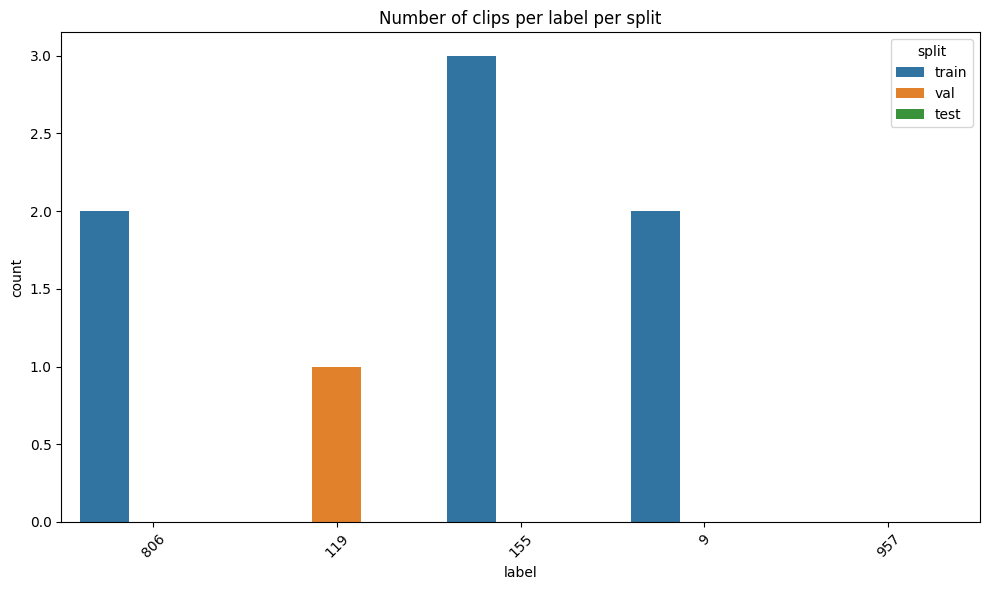

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principal component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

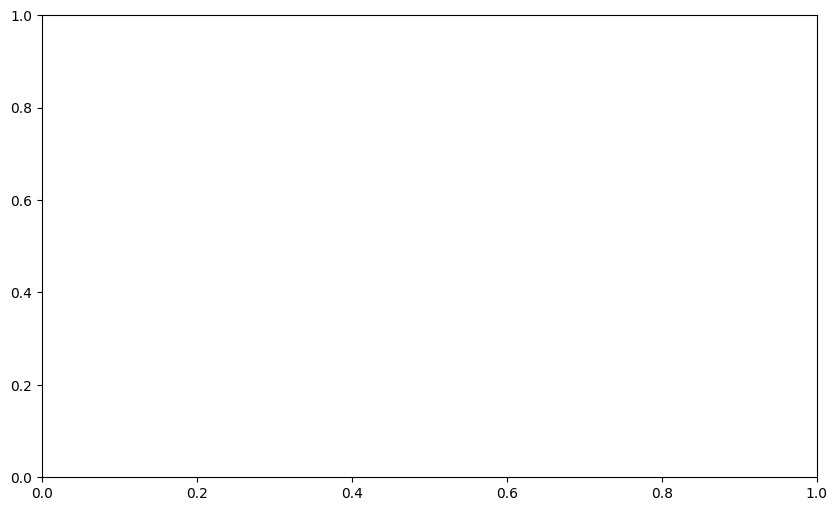

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob


def plot_clip_counts(base_dir):
    split_dirs = ["train", "val", "test"]
    all_counts = []

    for split in split_dirs:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            continue
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                clip_count = len(glob.glob(os.path.join(label_path, "*.mp4")))
                all_counts.append({"split": split, "label": label, "count": clip_count})
    
    df_counts = pd.DataFrame(all_counts)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_counts, x="label", y="count", hue="split")
    plt.title("Number of clips per label per split")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_clip_counts(OUTPUT_DIR)

def collect_clip_durations(base_dir):
    durations = []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.endswith(".mp4"):
                path = os.path.join(root, f)
                cap = cv2.VideoCapture(path)
                fps = cap.get(cv2.CAP_PROP_FPS)
                frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                duration = frames / fps if fps > 0 else 0
                label = os.path.basename(os.path.dirname(path))
                split = os.path.basename(os.path.dirname(os.path.dirname(path)))
                durations.append({"split": split, "label": label, "duration": duration})
                cap.release()
                
    return pd.DataFrame(durations)

df_durations = collect_clip_durations(OUTPUT_DIR)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_durations, x="duration", hue="split", bins=20, kde=True)
plt.title("Distribution of Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

Empty DataFrame
Columns: []
Index: []


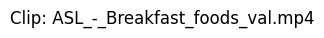

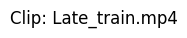

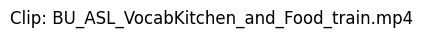

KeyError: 'duration'

<Figure size 1000x500 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import cv2
import pandas as pd
import seaborn as sns


def show_sample_frames(base_dir, num_clips=3, frames_per_clip=5):
    mp4_files = glob.glob(os.path.join(base_dir, "**", "*.mp4"), recursive=True)
    samples = random.sample(mp4_files, min(num_clips, len(mp4_files)))

    for clip_path in samples:
        cap = cv2.VideoCapture(clip_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = max(1, total_frames // frames_per_clip)
        frame_indices = [i * step for i in range(frames_per_clip)]
        
        fig, axes = plt.subplots(1, frames_per_clip, figsize=(15, 3))
        fig.suptitle(f"Clip: {os.path.basename(clip_path)}", fontsize=12)

        for i, frame_idx in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axes[i].imshow(frame_rgb)
                axes[i].axis("off")
            else:
                axes[i].set_visible(False)

        cap.release()
        plt.tight_layout()
        plt.show()

def collect_mp4_stats(base_dir):
    stats = []

    for path in glob.glob(os.path.join(base_dir, "**", "*.mp4"), recursive=True):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            continue

        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frames / fps if fps > 0 else 0
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        label = os.path.basename(os.path.dirname(path))
        split = os.path.basename(os.path.dirname(os.path.dirname(path)))

        stats.append({
            "file": os.path.basename(path),
            "split": split,
            "label": label,
            "duration": duration,
            "fps": fps,
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
        })

        cap.release()

    return pd.DataFrame(stats)

df_stats = collect_mp4_stats(OUTPUT_DIR)
print(df_stats.head())
show_sample_frames(OUTPUT_DIR, num_clips=3, frames_per_clip=5)

plt.figure(figsize=(10, 5))
sns.histplot(df_stats["duration"], bins=30, kde=True)
plt.title("Distribution of Clip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df_stats["fps"], bins=20, kde=True)
plt.title("Distribution of FPS")
plt.xlabel("Frames per Second")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=df_stats, x="resolution", order=df_stats["resolution"].value_counts().index)
plt.title("Video Resolution Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Clips")
plt.xlabel("Resolution")
plt.show()

In [66]:
import os
import torch
import torch.nn as nn
import random
import numpy as np

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_video
from decord import VideoReader
from decord import cpu


class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=30, class_to_idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.num_frames = num_frames

        if class_to_idx is None:
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        else:
            self.class_to_idx = class_to_idx
            self.classes = list(class_to_idx.keys())

        self.video_paths = []
        for label in self.classes:
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for file in os.listdir(label_dir):
                    if file.endswith(".mp4"):
                        self.video_paths.append((os.path.join(label_dir, file), label))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        for _ in range(5):
            video_path, label = self.video_paths[idx]
            try:
                vr = VideoReader(video_path, ctx=cpu(0))
                total_frames = len(vr)
                if total_frames == 0:
                    raise ValueError("Empty video")

                if total_frames >= self.num_frames:
                    indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
                else:
                    indices = list(range(total_frames))
                    while len(indices) < self.num_frames:
                        indices += indices[:self.num_frames - len(indices)]
                frames = vr.get_batch(indices).asnumpy()

                images = [Image.fromarray(frame) for frame in frames]
                if self.transform:
                    images = [self.transform(img) for img in images]

                frames_tensor = torch.stack(images)
                label_idx = self.class_to_idx[label]
                return frames_tensor, label_idx

            except Exception as e:
                print(f"[Skipped] {video_path}: {e}")
                idx = (idx + 1) % len(self.video_paths)

        dummy = torch.zeros((self.num_frames, 3, 224, 224))
        return dummy, -1

In [67]:
video_transforms_old = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  
    transforms.RandomHorizontalFlip(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [68]:
video_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

In [69]:
from torchvision.datasets.folder import find_classes

classes, class_to_idx = find_classes(train_dir)

train_dataset = VideoDataset(train_dir, transform=video_transforms, class_to_idx=class_to_idx)
val_dataset = VideoDataset(val_dir, transform=video_transforms, class_to_idx=class_to_idx)
test_dataset = VideoDataset(test_dir, transform=video_transforms, class_to_idx=class_to_idx)

In [70]:
train_loader = DataLoader(
    train_dataset,
    batch_size=5,  
    shuffle=True,
    num_workers=0,
    persistent_workers=False
)

for frames, labels in train_loader:
    print("Train loader")
    print(f"Frames shape: {frames.shape}")
    print(f"Labels: {labels}")
    break

Train loader
Frames shape: torch.Size([1, 30, 3, 128, 128])
Labels: tensor([26])


In [71]:
val_loader = DataLoader(
    val_dataset,
    batch_size=5,  
    shuffle=True,
    num_workers=0,
    persistent_workers=False
)

for frames, labels in val_loader:
    print("Val Loader")
    print(f"frames shape: {frames.shape}")
    print(f"labels: {labels}")
    break

Val Loader
frames shape: torch.Size([1, 30, 3, 128, 128])
labels: tensor([10])


In [72]:
test_loader = DataLoader(
    test_dataset,
    batch_size=5,  
    shuffle=True,
    num_workers=0,  
    persistent_workers=False
)

for frames, labels in test_loader:
    print("Test Loader")
    print(f"frames shape: {frames.shape}")
    print(f"labels: {labels}")
    break

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
print("Train classes:", train_dataset.class_to_idx)
print("Val classes:  ", val_dataset.class_to_idx)
print("Test classes: ", test_dataset.class_to_idx)

assert train_dataset.class_to_idx == val_dataset.class_to_idx == test_dataset.class_to_idx, \
    "Mismatch in class_to_idx between datasets!"

In [ ]:
from collections import Counter
import os

train_class_counts = Counter()
for path, cls in train_dataset.video_paths:
    train_class_counts[cls] += 1

print(train_class_counts)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetForVideoClassification(nn.Module):
    def __init__(self, num_classes, num_frames=30, dropout_prob=0.5):
        super().__init__()
        self.num_frames = num_frames
        
        base_model = models.resnet18(pretrained=True)
        feature_dim = base_model.fc.in_features
        base_model.fc = nn.Identity()
        self.resnet = base_model

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        batch_size, frames, c, h, w = x.shape
        x = x.view(-1, c, h, w) 

        features = self.resnet(x)  
        features = features.view(batch_size, frames, -1) 
        features = features.mean(dim=1)  

        features = self.dropout(features)
        return self.fc(features)

In [ ]:
from tqdm import tqdm
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_dataset.classes)
num_frames = 30

labels = [train_dataset.classes.index(label) for _, label in train_dataset.video_paths]
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=labels)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

model = ResNetForVideoClassification(num_classes=num_classes, num_frames=num_frames).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    scheduler.step()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training", leave=False)

    for frames, labels in train_bar:
        frames = frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_bar = tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation", leave=False)

    with torch.no_grad():
        for frames, labels in val_bar:
            frames = frames.to(device)
            labels = labels.to(device)
            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            val_bar.set_postfix(loss=loss.item(), acc=100 * val_correct / val_total)

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch

model.eval()
y_true = []
y_pred = []

unnormalize = T.Normalize(mean=[-0.5/0.5]*3, std=[1/0.5]*3)

def show_video_clip(frames_tensor, true_label, pred_label, class_names):
    frames_tensor = frames_tensor.cpu()
    T_frames = frames_tensor.shape[0]

    plt.figure(figsize=(T_frames * 2, 3))

    for t in range(T_frames):
        frame = unnormalize(frames_tensor[t])
        frame = torch.clamp(frame, 0, 1)  
        np_frame = frame.permute(1, 2, 0).numpy()

        plt.subplot(1, T_frames, t + 1)
        plt.imshow(np_frame)
        plt.axis('off')
        plt.title(f"t={t}")

    plt.suptitle(f"True: {class_names[true_label]} | Pred: {class_names[pred_label]}", fontsize=14)
    plt.tight_layout()
    plt.show()

with torch.no_grad():
    for frames, labels in test_loader:
        frames = frames.to(device)
        labels = labels.to(device)
        outputs = model(frames)
        preds = outputs.argmax(dim=1)
        
        mask = labels != -1
        y_true.extend(labels[mask].cpu().numpy())
        y_pred.extend(preds[mask].cpu().numpy())

print(f"Unique classes in y_true: {len(np.unique(y_true))}")
print(f"Classes predicted in y_pred: {np.unique(y_pred)}")

missing_classes = set(test_dataset.classes) - set(np.unique(y_true))
print(f"Missing classes: {missing_classes}")

print(classification_report(y_true, y_pred, target_names=test_dataset.classes, labels=np.unique(y_true)))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

frames, labels = next(iter(test_loader))
frames = frames.to(device)
outputs = model(frames)
preds = outputs.argmax(dim=1)

for i in range(len(frames)):
    show_video_clip(frames[i], labels[i], preds[i], class_names=test_dataset.classes)
    break 

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()